SOLD2 setup

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib
import matplotlib.colors as mcolors
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import torch
from scipy.spatial import distance_matrix

# load model
sold2 = KF.SOLD2(pretrained=True, config=None)


# image processing functions
def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb

def canny_preprocess(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)
    edges_and_mask = cv2.cvtColor(edges_and_mask, cv2.COLOR_GRAY2RGB)
    #augmented_img = edges_and_mask + img
    return edges_and_mask

def center_crop(img, dim):
    height, width = img.shape[0], img.shape[1]
    mid_y, mid_x = int(height / 2), int(width / 2)

    crop_height, crop_width = int(dim[0] / 2), int(dim[1] / 2)
    y_offset = mid_y - crop_height
    x_offset = mid_x - crop_width
    crop_img = img[y_offset: (mid_y + crop_height), x_offset: (mid_x + crop_width)]
    return(crop_img, y_offset, x_offset)

def kornia_load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # loads saved image into 1080 x 1920 x 3 (BGR)
    # print('img.shape: {}'.format(img.shape))
    # plt.imshow(img) # colors are BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB order: 1080 x 1920 x 3 (RGB)
    #a = img[:, :, 0] / 255.0
    #print('img.shape: {}'.format(img.shape))
    #plt.imshow(img) # colors are RGB
    img = K.image_to_tensor(img).float() / 255.0 # convert to 3 x 1080 x 1920 (RGB)
    #b = img[0, :, :].numpy()
    #assert(np.allclose(a, b))
    #print('img.shape: {}'.format(img.shape))
    #out = K.tensor_to_image(img)
    #plt.imshow(out)
    return img


# plotting functions

def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

SOLD2 demo

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_42218/477355501.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)
rgb.shape: (1080, 1920, 3)
rgb.dtype: uint8
img.shape: torch.Size([3, 720, 1280])
img.dtype: torch.float32
img.shape: torch.Size([1, 720, 1280])
img.dtype: torch.float32


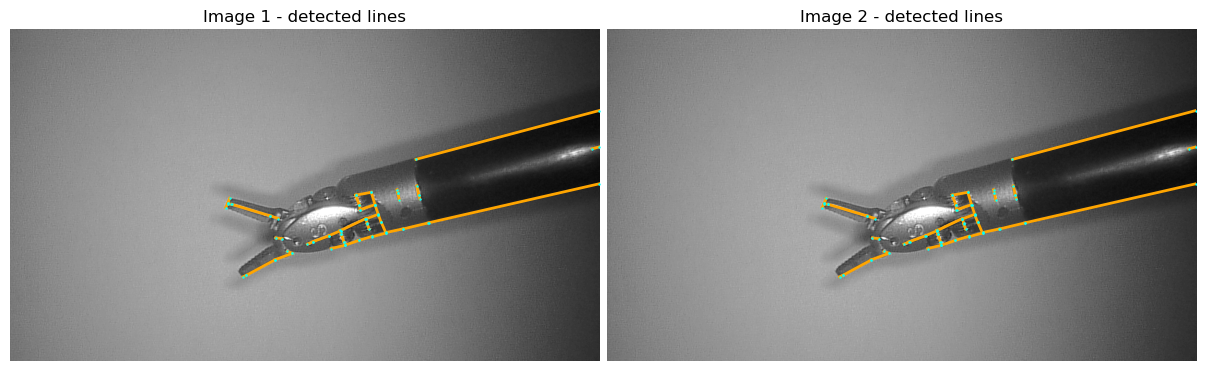

In [5]:
# left camera
crop_dims = (720, 1280)
chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # (1080, 1920, 3) ndarray uint8 [0, 255]
        cv2.imwrite('error_img.jpg', rgb)
        print('rgb.shape: {}'.format(rgb.shape))
        print('rgb.dtype: {}'.format(rgb.dtype))
        # center crop
        rgb, y_offset, x_offset = center_crop(rgb, crop_dims)
        img = K.image_to_tensor(rgb).float() / 255.0 # [0, 1] torch.float32 [3, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        img = K.color.rgb_to_grayscale(img) # [0, 1] torch.float32 [1, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        imgs = torch.stack([img, img], )
        #imgs = torch.stack([img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
#imgs_to_plot = [K.tensor_to_image(img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]
#lines_to_plot = [line_seg1.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
#plot_images(imgs_to_plot, ["Image - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})
#plot_lines(lines_to_plot, ps=3, lw=2, indices={0})

In [ ]:
# extract reference line heatmap
line_heatmap = np.asarray(outputs['line_heatmap'][0]) # output has size crop_dims: (h, w)
print('(h, w): {}'.format(line_heatmap.shape))
plt.imshow(line_heatmap, cmap = 'hot')

In [ ]:
# extract end points
junction_heatmap = np.asarray(outputs['junction_heatmap'][0]) # output has size crop_dims: (h, w)
print('(h, w): {}'.format(junction_heatmap.shape))
plt.imshow(junction_heatmap, cmap = 'hot')

In [ ]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

Create L/R cropped reference image

crop_scale: 0.5
rgb.shape: (1080, 1920, 3)


/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_55829/355584197.py:50: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)
/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_55829/355584197.py:50: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)
processImage: (1080, 1920, 3), (1080, 1920, 3)
left_image.shape: (540, 960, 3), right_image.shape: (540, 960, 3)
left_image.shape: (270, 480, 3), right_image.shape: (270, 480, 3)


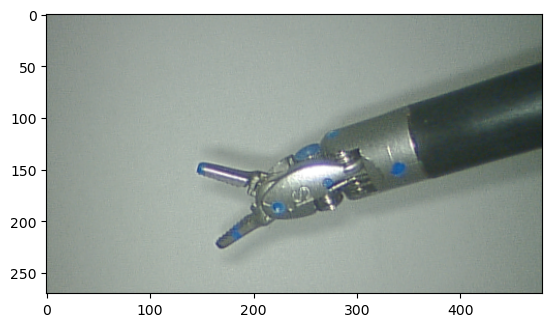

In [1]:
draw_contours = False
if (draw_contours):
    source_dir = 'ref_data/contour/'
else:
    source_dir = 'ref_data/no_contour/'

import time
import cv2
import kornia as K
import kornia.feature as KF
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from RobotLink_kornia import *
from StereoCamera_kornia import *
from ParticleFilter_kornia import *
from probability_functions_kornia import *
from utils_kornia import *

# File inputs
robot_file    = '../../journal_dataset/LND.json'
camera_file   = '../../journal_dataset/camera_calibration.yaml'
hand_eye_file = '../../journal_dataset/handeye.yaml'

crop_scale = 0.5
out_file = source_dir + 'crop_scale.npy'
np.save(out_file, crop_scale)
crop_scale = np.load('crop_scale.npy')
print('crop_scale: {}'.format(crop_scale))

robot_arm = RobotLink(robot_file, use_dh_offset=False) # position / orientation in Meters
cam = StereoCamera(camera_file, rectify = True, crop_scale = crop_scale)

# Load hand-eye transform 
# originally in M
f = open(hand_eye_file)
hand_eye_data = yaml.load(f, Loader=yaml.FullLoader)

cam_T_b = np.eye(4)
cam_T_b[:-1, -1] = np.array(hand_eye_data['PSM1_tvec'])/1000.0 # convert to mm
cam_T_b[:-1, :-1] = axisAngleToRotationMatrix(hand_eye_data['PSM1_rvec'])

# image processing functions
def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb

# read first image from left_cam
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
rgb_l = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0, 255]

# read first image from right_cam
data = pd.read_csv('../../journal_dataset/stereo-right-image.csv', nrows = 1)
raw_string = data['data'][0]
rgb_r = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0, 255]

# process images
new_left_img, new_right_img = cam.processImage(rgb_l, rgb_r, crop_scale = crop_scale)
_, new_left_img  = segmentColorAndGetKeyPoints(new_left_img,  draw_contours = draw_contours)
_, new_right_img = segmentColorAndGetKeyPoints(new_right_img, draw_contours = draw_contours)

# save ref images
out_file = source_dir + 'crop_ref_l_img.npy'
np.save(out_file, new_left_img) # (crop_height, crop_width, 3) RGB uint8
out_file = source_dir + 'crop_ref_r_img.npy'
np.save(out_file, new_right_img) # (crop_height, crop_width, 3) RGB uint8
plt.imshow(new_right_img)


Display reference images

(270, 480, 3)

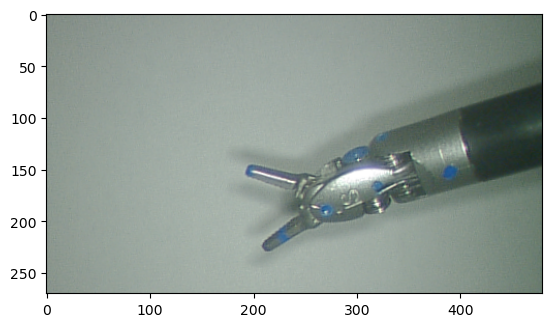

In [2]:
import numpy as np
import matplotlib.pyplot as plt

draw_contours = False
if (draw_contours):
    source_dir = 'ref_data/contour/'
else:
    source_dir = 'ref_data/no_contour/'

out_file = source_dir + 'crop_ref_l_img.npy'
img = np.load(out_file)
plt.imshow(np.load(out_file))
img.shape

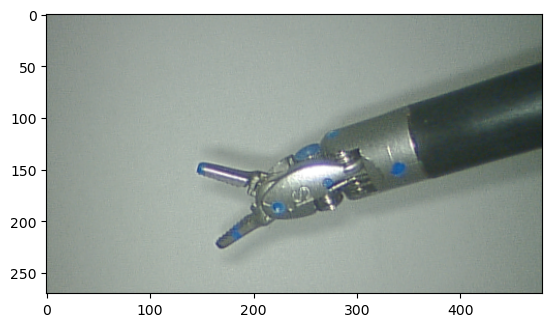

In [2]:
out_file = source_dir + 'crop_ref_r_img.npy'
plt.imshow(np.load(out_file))

Use cropped image as reference image, save reference params

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_54439/3455525845.py:44: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)
processImage: (1080, 1920, 3), (1080, 1920, 3)
left_image.shape: (540, 960, 3), right_image.shape: (540, 960, 3)
left_image.shape: (270, 480, 3), right_image.shape: (270, 480, 3)


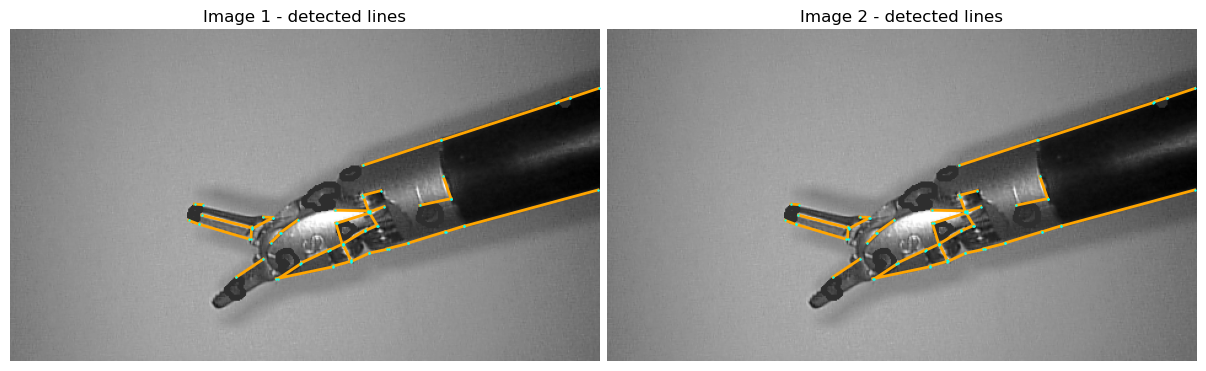

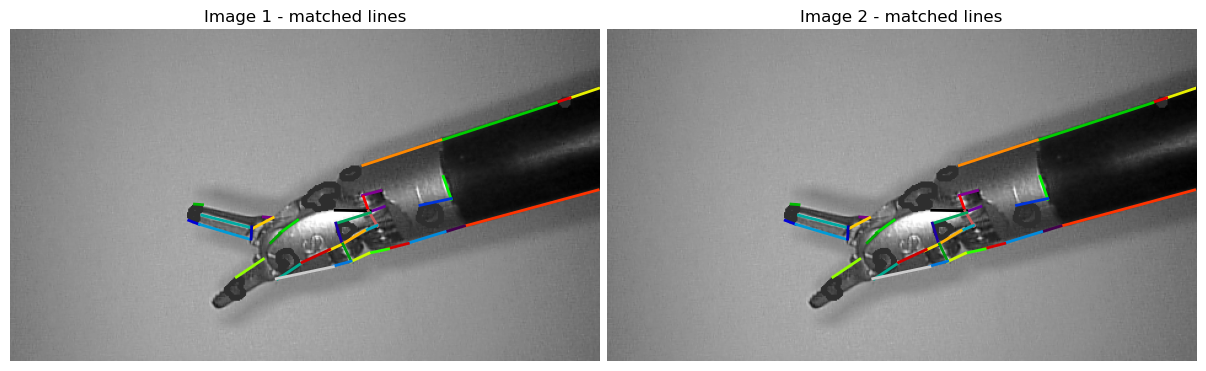

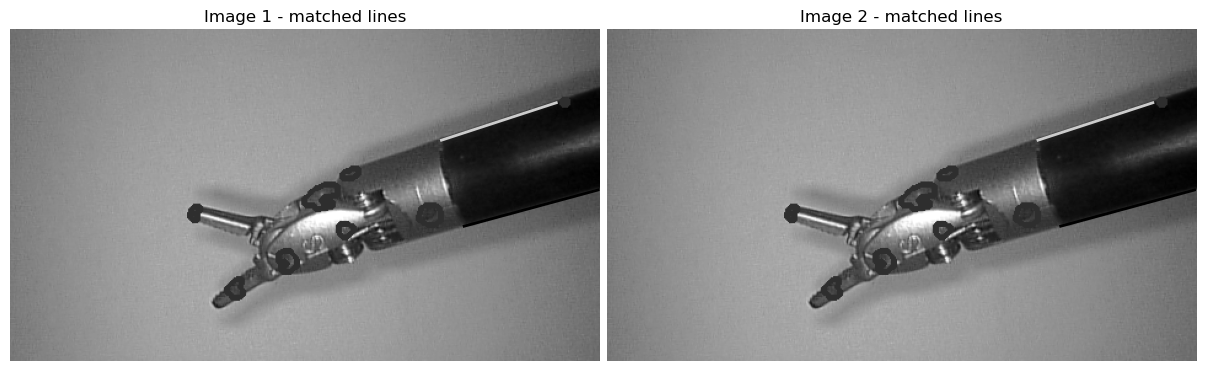

In [1]:
camera = 'right'
draw_contours = True
if (draw_contours):
    source_dir = 'ref_data/contour/'
else:
    source_dir = 'ref_data/no_contour/'

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib
import matplotlib.colors as mcolors
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import torch
from scipy.spatial import distance_matrix
import time
import os
import sys

from RobotLink_kornia import *
from StereoCamera_kornia import *
from ParticleFilter_kornia import *
from probability_functions_kornia import *
from utils_kornia import *

# File inputs
robot_file    = '../../journal_dataset/LND.json'
camera_file   = '../../journal_dataset/camera_calibration.yaml'
hand_eye_file = '../../journal_dataset/handeye.yaml'

# load model
sold2 = KF.SOLD2(pretrained=True, config=None)

# image processing functions
def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb  

# plotting functions
def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=5, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=5, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

robot_arm = RobotLink(robot_file, use_dh_offset=False) # position / orientation in Meters
crop_scale = np.load('crop_scale.npy') # array([ crop_height, crop_width])
cam = StereoCamera(camera_file, rectify = True, crop_scale = crop_scale)

# Load hand-eye transform 
# originally in M
f = open(hand_eye_file)
hand_eye_data = yaml.load(f, Loader=yaml.FullLoader)

cam_T_b = np.eye(4)
cam_T_b[:-1, -1] = np.array(hand_eye_data['PSM1_tvec'])/1000.0 # convert to mm
cam_T_b[:-1, :-1] = axisAngleToRotationMatrix(hand_eye_data['PSM1_rvec'])

if (camera == 'left'):
    # LEFT IMAGE
    # use cropped image as ref image
    in_file = source_dir + 'crop_ref_l_img.npy'
    ref_img = np.load(in_file) # (crop_dims, 3) RGB uint8
    ref_tensor = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
    ref_tensor = K.color.rgb_to_grayscale(ref_tensor) # [0, 1] torch.Size([1, crop_dims]) torch.float32

    data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
    raw_string = data['data'][0]
    rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
    new_img, _ = cam.processImage(rgb, rgb, crop_scale = crop_scale)
else:
    # RIGHT IMAGE
    # use cropped image as ref image
    in_file = source_dir + 'crop_ref_r_img.npy' # (crop_dims, 3) RGB uint8
    ref_img = np.load(in_file)
    ref_tensor = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
    ref_tensor = K.color.rgb_to_grayscale(ref_tensor) # [0, 1] torch.Size([1, crop_dims]) torch.float32

    data = pd.read_csv('../../journal_dataset/stereo-right-image.csv', nrows = 1)
    raw_string = data['data'][0]
    rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
    _, new_img = cam.processImage(rgb, rgb, crop_scale = crop_scale)

_, new_img  = segmentColorAndGetKeyPoints(new_img,  draw_contours=draw_contours)
new_tensor = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
new_tensor = K.color.rgb_to_grayscale(new_tensor) # [0, 1] [1, crop_dims] float32
tensors = torch.stack([ref_tensor, new_tensor], )
with torch.inference_mode():
    outputs = sold2(tensors)

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(ref_tensor), K.tensor_to_image(new_tensor)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = copy.deepcopy(line_seg1[valid_matches])

if (camera == 'left'):
    out_file = source_dir + 'crop_ref_lines_l.npy' 
else:
    out_file = source_dir + 'crop_ref_lines_r.npy'
np.save(out_file, matched_lines1)
matched_lines1 = torch.as_tensor(np.load(out_file))
matched_lines2 = line_seg2[match_indices]

sort_column = 0
values, indices = matched_lines1[:, :, sort_column].sort()
sorted_matched_lines1 = matched_lines1[[[x] for x in range(matched_lines1.shape[0])], indices]
if (camera == 'left'):
    out_file = source_dir + 'crop_ref_lines_l_sorted.npy'
else:
    out_file = source_dir + 'crop_ref_lines_r_sorted.npy'
np.save(out_file, sorted_matched_lines1)
sorted_matched_lines1 = torch.as_tensor(np.load(out_file))

assert(np.allclose(np.asarray(matched_lines1), np.asarray(sorted_matched_lines1)))

# plot matched lines
imgs_to_plot = [K.tensor_to_image(ref_tensor), K.tensor_to_image(new_tensor)]

plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

# Save L reference lines
# pick only shaft lines in reference image by length (largest 2x lines)
reference_line_lengths = []
for i in range(matched_lines1.shape[0]):
    reference_line_lengths.append(np.linalg.norm(matched_lines1[i][0] - matched_lines1[i][1]))
reference_line_lengths = np.asarray(reference_line_lengths)
ind = np.argpartition(reference_line_lengths, -2)[-2:]

if (camera == 'left'):
    if (draw_contours):
        ind = [0, 13]
    else:
        ind = [0, 9]
    out_file = source_dir + 'crop_ref_lines_l_idx.npy'
else:
    if (draw_contours):
        ind = [2, 5]
    else:
        ind = [0, 3]
    out_file = source_dir + 'crop_ref_lines_r_idx.npy'
np.save(out_file, ind)
ind = np.asarray(np.load(out_file))

# plot matched shaft lines only
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
selected_lines1 = copy.deepcopy(matched_lines1[ind])

if (camera == 'left'):
    out_file = source_dir + 'crop_ref_lines_l_selected.npy'
else:
    out_file = source_dir + 'crop_ref_lines_r_selected.npy'
np.save(out_file, selected_lines1)
selected_lines1 = torch.as_tensor(np.load(out_file))

selected_lines2 = matched_lines2[ind]
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

In [2]:
import numpy as np
img = np.load('ref/contour/crop_ref_l_img.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'ref/contour/crop_ref_l_img.npy'

Test index into cropped image w/image stream

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_82186/2819341212.py:46: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


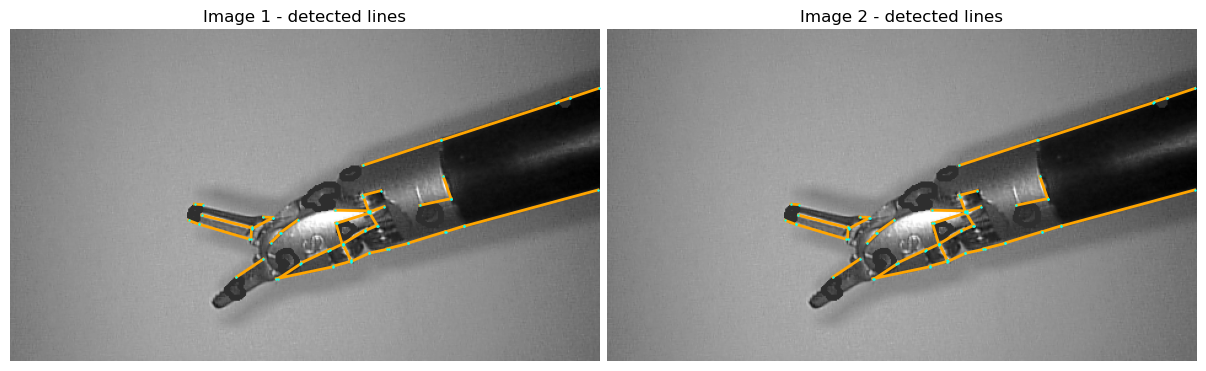

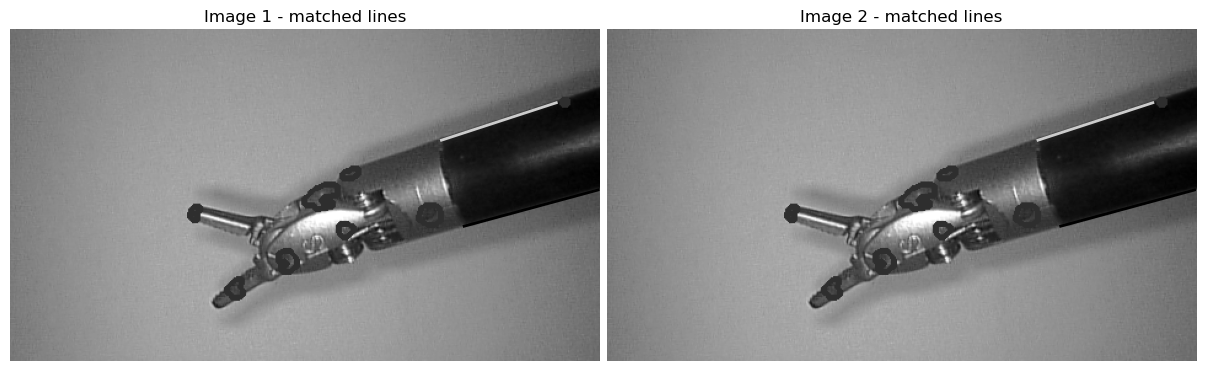

In [1]:
camera = 'right'
draw_contours = True
if (draw_contours):
    source_dir = 'ref_data/contour/'
else:
    source_dir = 'ref_data/no_contour/'

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib
import matplotlib.colors as mcolors
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import torch
from scipy.spatial import distance_matrix
import time
import os
import sys

from RobotLink_kornia import *
from StereoCamera_kornia import *
from ParticleFilter_kornia import *
from probability_functions_kornia import *
from utils_kornia import *

# File inputs
robot_file    = '../../journal_dataset/LND.json'
camera_file   = '../../journal_dataset/camera_calibration.yaml'
hand_eye_file = '../../journal_dataset/handeye.yaml'


# load model
sold2 = KF.SOLD2(pretrained=True, config=None)


# image processing functions
def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb  

# plotting functions
def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=10, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=10, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

robot_arm = RobotLink(robot_file, use_dh_offset=False) # position / orientation in Meters
crop_scale = np.load('crop_scale.npy') # array([ crop_height, crop_width])
cam = StereoCamera(camera_file, rectify = True, crop_scale = crop_scale)

# Load hand-eye transform 
# originally in M
f = open(hand_eye_file)
hand_eye_data = yaml.load(f, Loader=yaml.FullLoader)

cam_T_b = np.eye(4)
cam_T_b[:-1, -1] = np.array(hand_eye_data['PSM1_tvec'])/1000.0 # convert to mm
cam_T_b[:-1, :-1] = axisAngleToRotationMatrix(hand_eye_data['PSM1_rvec'])

if (camera == 'left'):

    # LEFT IMAGE
    # use cropped image as ref image
    in_file = source_dir + 'crop_ref_l_img.npy'
    ref_img = np.load(in_file) # (crop_dims, 3) RGB uint8
    ref_tensor = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
    ref_tensor = K.color.rgb_to_grayscale(ref_tensor) # [0, 1] torch.Size([1, crop_dims]) torch.float32

    data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
    raw_string = data['data'][0]
    rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
    new_img, _ = cam.processImage(rgb, rgb, crop_scale = crop_scale)
else:
    # RIGHT IMAGE
    # use cropped image as ref image
    in_file = source_dir + 'crop_ref_r_img.npy'
    ref_img = np.load(in_file) # (crop_dims, 3) RGB uint8
    ref_tensor = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
    ref_tensor = K.color.rgb_to_grayscale(ref_tensor) # [0, 1] torch.Size([1, crop_dims]) torch.float32

    data = pd.read_csv('../../journal_dataset/stereo-right-image.csv', nrows = 1)
    raw_string = data['data'][0]
    rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
    _, new_img = cam.processImage(rgb, rgb, crop_scale = crop_scale)


_, new_img  = segmentColorAndGetKeyPoints(new_img,  draw_contours = draw_contours)
new_tensor = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
new_tensor = K.color.rgb_to_grayscale(new_tensor) # [0, 1] [1, crop_dims] float32
tensors = torch.stack([ref_tensor, new_tensor], )
with torch.inference_mode():
    outputs = sold2(tensors)

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(ref_tensor), K.tensor_to_image(new_tensor)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = copy.deepcopy(line_seg1[valid_matches])

if (camera == 'left'):
    in_file = source_dir + 'crop_ref_lines_l.npy'
else:
    in_file = source_dir + 'crop_ref_lines_r.npy'
crop_ref_lines = np.load(in_file)
assert(np.allclose(np.asarray(matched_lines1), np.asarray(crop_ref_lines)))
matched_lines2 = line_seg2[match_indices]

# sort
sort_column = 0
values, indices = matched_lines1[:, :, sort_column].sort()
sorted_matched_lines1 = matched_lines1[[[x] for x in range(matched_lines1.shape[0])], indices]
values, indices = matched_lines2[:, :, sort_column].sort()
sorted_matched_lines2 = matched_lines2[[[x] for x in range(matched_lines2.shape[0])], indices]

if (camera == 'left'):
    in_file = source_dir + 'crop_ref_lines_l_sorted.npy'
else:
    in_file = source_dir + 'crop_ref_lines_r_sorted.npy'
crop_ref_lines_sorted = np.load(in_file)
assert(np.allclose(np.asarray(sorted_matched_lines1), np.asarray(crop_ref_lines_sorted)))

# pick only shaft lines by euclidean distance from selected lines
if (camera == 'left'):
    in_file = source_dir + 'crop_ref_lines_l_selected.npy'
else:
    in_file = source_dir + 'crop_ref_lines_r_selected.npy'
crop_ref_lines_selected = np.load(in_file)

if (camera == 'left'):
    in_file = source_dir + 'crop_ref_lines_l_idx.npy'
else:
    in_file = source_dir + 'crop_ref_lines_r_idx.npy'
crop_ref_lines_idx = np.load(in_file)

dist_matrix = torch.cdist(torch.flatten(torch.as_tensor(crop_ref_lines_selected), start_dim = 1), torch.flatten(sorted_matched_lines1, start_dim = 1))
ind = torch.argmin(dist_matrix, dim = 1)
selected_lines1 = sorted_matched_lines1[ind]
selected_lines2 = sorted_matched_lines2[ind]
assert(np.allclose(np.asarray(ind), np.asarray(crop_ref_lines_idx)))
assert(np.allclose(np.asarray(selected_lines1), np.asarray(crop_ref_lines_selected)))

# pick only shaft lines in reference image by length (largest 2x lines)
#reference_line_lengths = []
#for i in range(matched_lines1.shape[0]):
    #reference_line_lengths.append(np.linalg.norm(matched_lines1[i][0] - matched_lines1[i][1]))
#reference_line_lengths = np.asarray(reference_line_lengths)
#ind = np.argpartition(reference_line_lengths, -2)[-2:]

# plot matched shaft lines only
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

RESUME HERE

In [1]:
import numpy as np
import cv2
import imutils
import math
from scipy.cluster.hierarchy import fclusterdata
from scipy.spatial import distance_matrix
from sklearn import linear_model
import scipy.stats
import torch
import kornia as K
import kornia.feature as KF
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib
import matplotlib.colors as mcolors
import StereoCamera_kornia

def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb

# accepts single img and Nx2 [rho, theta] array of line parameters
# returns altered img
def drawPolarLines(img, lines, color = (0, 0, 255)):
    lines = lines.reshape(-1, 2)
    for i in range(lines.shape[0]):
        rho = lines[i, 0]
        theta = lines[i, 1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
        pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
        # BGR (255, 0, 0) = Blue
        cv2.line(img, pt1, pt2, color, 2)
    
    return img

def detectCannyShaftLines(img = None, 
                          hough_rho_accumulator = None, 
                          hough_theta_accumulator = None, 
                          hough_vote_threshold = None,
                          rho_cluster_distance = None,
                          theta_cluster_distance = None 
                          ):

    # pre-processing
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)

   # detect lines
    lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = hough_rho_accumulator, theta = hough_theta_accumulator, threshold = hough_vote_threshold) 
    lines = np.squeeze(lines)
    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = rho_cluster_distance, criterion = 'distance', method = 'complete')
    theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = theta_cluster_distance, criterion = 'distance', method = 'complete')

    best_lines = []
    checked_clusters = []
    for i in range(sorted_lines.shape[0]):
        rho_cluster = rho_clusters[i]
        theta_cluster = theta_clusters[i]
        cluster = (rho_cluster, theta_cluster)
        if (cluster in checked_clusters):
            continue
        best_lines.append([lines[i, 0], lines[i, 1]])
        checked_clusters.append(cluster)

    best_lines = np.asarray(best_lines)

    # check for negative rho, add 2*pi to theta
    best_lines[:, 1][best_lines[:, 0] < 1] = best_lines[:, 1][best_lines[:, 0] < 1] + 2 * np.pi
    # replace negative rho with abs(rho)
    best_lines[:, 0][best_lines[:, 0] < 0] = best_lines[:, 0][best_lines[:, 0] < 1] * -1

    # eliminate vertical lines
    vertical_line_mask = []
    for i in range(best_lines.shape[0]):
        theta = best_lines[i, 1]
        if (theta > -10 * np.pi / 180) and (theta < 10 * np.pi / 180):
            vertical_line_mask.append(False)
        elif (theta > 170 * np.pi / 180) and (theta < 190 * np.pi / 180):
            vertical_line_mask.append(False)
        else:
            vertical_line_mask.append(True)
    best_lines = best_lines[vertical_line_mask, :]

    # draw all detected and clustered edges
    # (B, G, R)
    img = drawPolarLines(img, best_lines[:, 0:2], color = (0, 0, 255))

    # returns Nx2 array of # N detected lines x [rho, theta], img with lines drawn, edges and mask
    return best_lines[:, 0:2], img

# canny image augmentation for kornia network
def cannyPreProcess_kornia(img):

    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)
    edges_and_mask = cv2.cvtColor(edges_and_mask, cv2.COLOR_GRAY2RGB)
    return edges_and_mask

def centerCrop(img, dim):
    height, width = img.shape[0], img.shape[1]
    mid_y, mid_x = int(height / 2), int(width / 2)

    crop_height, crop_width = int(dim[0] / 2), int(dim[1] / 2)
    y_offset = mid_y - crop_height
    x_offset = mid_x - crop_width
    crop_img = img[y_offset: (mid_y + crop_height), x_offset: (mid_x + crop_width)]
    return(crop_img, y_offset, x_offset)

# accepts single img and torch[2, 2, 2] tensor of line segment endpoints
# returns altered img
def drawLineSegments(img = None, lines = None, colors = [(255, 0, 0), (0, 255, 0)]):
    
    # BGR (255, 0, 0) = Blue
    for i in range(lines.shape[0]):
        endpoints = lines[i, :, :]
        y1 = int(endpoints[0, 0])
        x1 = int(endpoints[0, 1])
        y2 = int(endpoints[1, 0])
        x2 = int(endpoints[1, 1])
        pt1 = (x1, y1)
        pt2 = (x2, y2)
        cv2.line(img, pt1, pt2, colors[i], 2)
    
    return img

def fitRansacLines(point_clouds, ransac_params):
    
    # ransac params
    min_samples = int(ransac_params['min_samples'])
    residual_threshold = ransac_params['residual_threshold']
    max_trials = ransac_params['max_trials']
    
    # fit point clouds
    lines = []
    for cloud in point_clouds:
        
        # data
        X = cloud[:, 1].reshape(-1, 1)
        y = cloud[:, 0].reshape(-1, 1)
        residual_threshold *= scipy.stats.median_abs_deviation(y, axis = None)
        ransac = linear_model.RANSACRegressor(min_samples = min_samples, residual_threshold = residual_threshold, max_trials = max_trials)
        
        # sequential ransac
        while (True):
            try: 
                ransac.fit(X, y)
                inlier_mask = ransac.inlier_mask_
                outlier_mask = np.logical_not(inlier_mask)
                m = float(ransac.estimator_.coef_)
                b = float(ransac.estimator_.intercept_)
                y1, x1 = int(b), 0
                y2, x2 = int(m * crop_ref_dims[1] + b), crop_ref_dims[1]
                theta = np.arctan2((x1 - x2), (y2 - y1))
                rho = x1 * np.cos(theta) + y1 * np.sin(theta)

                # convert to hough line bounds
                if (theta < 0) and (theta >= -np.pi):
                    theta += np.pi
                    rho *= -1
                elif (theta < -np.pi) and (theta >= -2 * np.pi):
                    theta += 2 * np.pi
                    rho = rho
                elif (theta >= np.pi) and (theta <= 2 * np.pi):
                    theta -= np.pi
                    rho *= -1
                
                lines.append([rho, theta])
                X = X[outlier_mask]
                y = y[outlier_mask]
                if (len(X) <= min_samples or len(y) <= min_samples):
                    break
            except:
                pass
    return lines

def detectShaftLines_kornia(new_img = None, 
                            ref_img = None, 
                            crop_ref_lines = None, 
                            crop_ref_dims = None, 
                            model = None, 
                            canny_params = {},
                            kornia_params = {}):

    # center crop new_img
    new_img, y_offset, x_offset = centerCrop(new_img, crop_ref_dims) # crop_dims x 3 (RGB) uint8 ndarray [0 255]

    # use canny edge detection
    canny_lines = None
    if ((canny_params is not None) and (canny_params['use_canny'])):
        
        # check that all params are used
        assert(None not in canny_params.values())

        hough_rho_accumulator = canny_params['hough_rho_accumulator']
        hough_theta_accumulator = canny_params['hough_theta_accumulator']
        hough_vote_threshold = canny_params['hough_vote_threshold']
        rho_cluster_distance = canny_params['rho_cluster_distance']
        theta_cluster_distance = canny_params['theta_cluster_distance']

        canny_lines, new_img = detectCannyShaftLines(
                        img = new_img, 
                        hough_rho_accumulator = hough_rho_accumulator, 
                        hough_theta_accumulator = hough_theta_accumulator, 
                        hough_vote_threshold = hough_vote_threshold,
                        rho_cluster_distance = rho_cluster_distance,
                        theta_cluster_distance = theta_cluster_distance
                        )
        
    else: # use kornia
        assert((kornia_params is not None) and (kornia_params['use_kornia']))

    # process input image
    orig_img = new_img.copy()
    new_img = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
    new_img = K.color.rgb_to_grayscale(new_img) # [0, 1] [1, crop_dims] float32
    imgs = torch.stack([ref_img, new_img], )
    with torch.inference_mode():
        outputs = model(imgs)
    
    # detect line segments
    line_seg1 = outputs["line_segments"][0]
    line_seg2 = outputs["line_segments"][1]
    desc1 = outputs["dense_desc"][0]
    desc2 = outputs["dense_desc"][1]
    line_heatmap1 = np.asarray(outputs['line_heatmap'][0])
    line_heatmap2 = np.asarray(outputs['line_heatmap'][1])

    # perform association between All line segments 
    # in ref_img and new_img
    with torch.inference_mode():
        matches = model.match(line_seg1, line_seg2, desc1[None], desc2[None])
    valid_matches = matches != -1
    match_indices = matches[valid_matches]

    matched_lines1 = line_seg1[valid_matches]
    matched_lines2 = line_seg2[match_indices]

    # sort matched line segments from ref_img by y-coordinate
    sort_column = 0
    values, indices = matched_lines1[:, :, sort_column].sort()
    sorted_matched_lines1 = matched_lines1[[[x] for x in range(matched_lines1.shape[0])], indices]

    # load ref lines and find only those lines in ref_img line segments (matched_lines1)
    # using y coordinate
    dist_matrix = torch.cdist(torch.flatten(crop_ref_lines, start_dim = 1), torch.flatten(sorted_matched_lines1, start_dim = 1))
    ind = torch.argmin(dist_matrix, dim = 1)

    # select only matching line segments that correspond to ref lines
    selected_lines1 = matched_lines1[ind] # ref lines torch[2, 2, 2]
    ref_img = np.load('crop_ref_l.npy')
    ref_img = drawLineSegments(ref_img, selected_lines1)
    selected_lines2 = matched_lines2[ind] # matched lines in new_img torch[2, 2, 2]
    new_img = drawLineSegments(orig_img, selected_lines2)

    # new image detected endpoints
    detected_endpoints = np.asarray(np.around(np.asarray(selected_lines2), decimals = 0), dtype = int) # [[y, x], [y, x]]

    # convert detected endpoints to rho, theta form
    endpoints_to_polar = kornia_params['endpoints_to_polar'] # boolean
    polar_lines_detected_endpoints = None
    if (endpoints_to_polar):
        polar_lines_detected_endpoints = []
        for line in detected_endpoints:
            y1 = line[0][0]
            x1 = line[0][1]
            y2 = line[1][0]
            x2 = line[1][1]

            theta = np.arctan2((x1 - x2), (y2 - y1))
            rho = x1 * np.cos(theta) + y1 * np.sin(theta)
            polar_lines_detected_endpoints.append([rho, theta])
            new_img = drawPolarLines(new_img, np.asarray([rho, theta]))

    # search region around detected endpoints for all pixels
    # that meet intensity threshold
    # return point cloud vs. rho, theta best fit ransac lines
    use_endpoint_intensities_only = kornia_params['use_endpoint_intensities_only'] # boolean
    endpoint_intensities_to_polar = kornia_params['endpoint_intensities_to_polar'] # boolean
    search_radius = int(kornia_params['search_radius']) # kernel size for dilation
    intensity_params = kornia_params['intensity_params'] # {'metric': value} {'mean': 0, 'std': 1, 'pct': 10}
    ransac_params = kornia_params['ransac_params'] # ransac params {'min_samples: 3, 'residual_threshold': None, 'max_trials': 100}
    
    intensity_endpoint_clouds = None
    intensity_endpoint_lines = None
    if (use_endpoint_intensities_only) or (endpoint_intensities_to_polar): # returns all intensity pixels
        
        intensity_endpoint_clouds = []
        kernel = np.ones((search_radius, search_radius), np.uint8)

        for line in detected_endpoints:
            y1 = line[0][0]
            x1 = line[0][1]
            y2 = line[1][0]
            x2 = line[1][1]

            # convert detected endpoints to endpoint intensity clouds
            blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
            dotted = blank.copy()
            dotted[y1, x1] = 255.0
            dotted[y2, x2] = 255.0

            dotted_dilation = cv2.dilate(dotted, kernel, iterations = 1)
            ys, xs = np.where(dotted_dilation)
            dilated_points = list(zip(list(ys), list(xs)))
            dilated_points_intensities = np.asarray([line_heatmap2[coord[0], coord[1]] for coord in dilated_points])

            metric = intensity_params['use_metric']
            if (metric == 'mean'):
                intensity_threshold = dilated_points_intensities.mean()
            elif (metric == 'std'):
                stds = intensity_params[metric]
                intensity_threshold = dilated_points_intensities.mean() + (stds * dilated_points_intensities.std())
            elif (metric == 'pct'):
                pct = float(intensity_params[metric])
                intensity_threshold = np.percentile(dilated_points_intensities, pct)
            
            intensity_mask = dilated_points_intensities >= intensity_threshold

            thresholded_dilated_points = np.asarray(dilated_points)[intensity_mask]
            intensity_endpoint_clouds.append(thresholded_dilated_points)

            if (endpoint_intensities_to_polar):
                intensity_endpoint_lines = fitRansacLines(intensity_endpoint_clouds, ransac_params)
                new_img = drawPolarLines(new_img, np.asarray(intensity_endpoint_lines))
    
    # search region between detected endpoints for all pixels
    # that meet intensity threshold
    # return point cloud vs. rho, theta best fit ransac lines
    use_line_intensities_only = kornia_params['use_line_intensities_only'] # boolean
    line_intensities_to_polar = kornia_params['line_intensities_to_polar'] # boolean
    intensity_line_clouds = None
    intensity_line_lines = None

    if (use_line_intensities_only) or (line_intensities_to_polar): # returns all intensity pixels
        
        intensity_line_clouds = []
        kernel = np.ones((search_radius, search_radius), np.uint8)

        for line in detected_endpoints:
            y1 = line[0][0]
            x1 = line[0][1]
            y2 = line[1][0]
            x2 = line[1][1]

            # convert detected endpoints to line intensity cloud
            blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
            lined = blank.copy()
            lined = cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), thickness = 1)
            lined_dilation = cv2.dilate(lined, kernel, iterations=1)
            ys, xs = np.where(lined_dilation)
            dilated_line = list(zip(list(ys), list(xs)))
            dilated_line_intensities = np.asarray([line_heatmap2[coord[0], coord[1]] for coord in dilated_line])

            metric = intensity_params['use_metric']
            if (metric == 'mean'):
                intensity_threshold = dilated_line_intensities.mean()
            elif (metric == 'std'):
                stds = intensity_params[metric]
                intensity_threshold = dilated_line_intensities.mean() + (stds * dilated_line_intensities.std())
            elif (metric == 'pct'):
                pct = float(intensity_params[metric])
                intensity_threshold = np.percentile(dilated_line_intensities, pct)

            intensity_mask = dilated_line_intensities >= intensity_threshold

            thresholded_dilated_line = np.asarray(dilated_line)[intensity_mask]
            intensity_line_clouds.append(thresholded_dilated_line)

            if (line_intensities_to_polar):
                intensity_line_lines = fitRansacLines(intensity_line_clouds, ransac_params)
                new_img = drawPolarLines(new_img, np.asarray(intensity_line_lines))
    
    output = {
        'ref_img': ref_img,
        'new_img': new_img,
        'canny_lines': canny_lines,
        'polar_lines_detected_endpoints': polar_lines_detected_endpoints,
        'intensity_endpoint_clouds': intensity_endpoint_clouds,
        'intensity_endpoint_lines': intensity_endpoint_lines,
        'intensity_line_clouds': intensity_line_clouds,
        'intensity_line_lines': intensity_line_lines
    }

    return output

def drawShaftLines(shaftFeatures, cam, cam_T_b, img_list):

    # Project points from base to 2D L/R camera image planes
    # Get shaft feature points and lines from FK transform in base frame
    p_b, d_b, _, r = shaftFeatures
    # Transform shaft featurepoints from base frame to camera-to-base frame
    p_c = np.dot(cam_T_b, np.transpose(np.concatenate((p_b, np.ones((p_b.shape[0], 1))), axis=1)))
    p_c = np.transpose(p_c)[:, :-1]
    
    # Rotate directions from base to camera frame (no translation)
    d_c = np.dot(cam_T_b[0:3, 0:3], np.transpose(d_b))
    d_c = np.transpose(d_c)
    
    # Project shaft lines from L and R camera-to-base frames onto 2D camera image plane
    projected_lines = cam.projectShaftLines(p_c, d_c, r)

    # (B, G, R)
    img_l = drawPolarLines(img_list[0], projected_lines[0], (0, 255, 0))
    img_r = drawPolarLines(img_list[1], projected_lines[1], (0, 255, 0))

    return img_l, img_r

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
canny_params = {
    'use_canny': True,
    'hough_rho_accumulator': 5.0,
    'hough_theta_accumulator': 0.09,
    'hough_vote_threshold': 100,
    'rho_cluster_distance': 5.0,
    'theta_cluster_distance': 0.09
}

kornia_params = {
    'use_kornia': False,
    'endpoints_to_polar': False,
    'use_endpoint_intensities_only': False,
    'endpoint_intensities_to_polar': False,
    'search_radius': 25.0,
    'intensity_params': {
        'use_metric': 'mean',
        'mean': 0,
        'std': 1.0,
        'pct': 10.0
    },
    'ransac_params': {
        'min_samples': 3.0,
        'residual_threshold': 0.75,
        'max_trials': 100,
        'crop_ref_dims': [720, 1280]
    },
    'use_line_intensities_only': False,
    'line_intensities_to_polar': True
} 

# load model
model = KF.SOLD2(pretrained=True, config=None)

# LEFT IMAGE
# match ref image with new image
ref_img = np.load('crop_ref_l.npy') # (crop_dims, 3) RGB uint8
ref_img = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
ref_img = K.color.rgb_to_grayscale(ref_img) # [0, 1] torch.Size([1, crop_dims]) torch.float32

crop_ref_dims = np.load('crop_ref_dims.npy') # array([ crop_height, crop_width])
crop_ref_lines = torch.as_tensor(np.load('crop_ref_lines_l.npy')) # torch.Size([2, 2, 2])

data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'].iloc[0]
rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]

'''
output = {
    'ref_img': ref_img,
    'new_img': new_img,
    'canny_lines': canny_lines,
    'polar_lines_detected_endpoints': polar_lines_detected_endpoints,
    'intensity_endpoint_clouds': intensity_endpoint_clouds,
    'intensity_endpoint_lines': intensity_endpoint_lines,
    'intensity_line_clouds': intensity_line_clouds,
    'intensity_line_lines': intensity_line_lines
}
'''

output = detectShaftLines_kornia(
                                new_img = rgb, 
                                ref_img = ref_img, 
                                crop_ref_lines = crop_ref_lines, 
                                crop_ref_dims = crop_ref_dims, 
                                model = model, 
                                canny_params = canny_params,
                                kornia_params = kornia_params
                            )

        


/tmp/ipykernel_389204/886493881.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


In [ ]:
output['in']

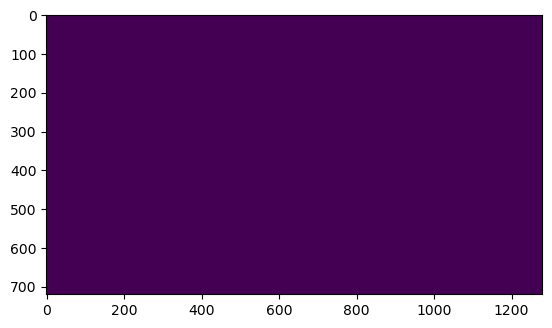

In [24]:
blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
plt.imshow(blank)

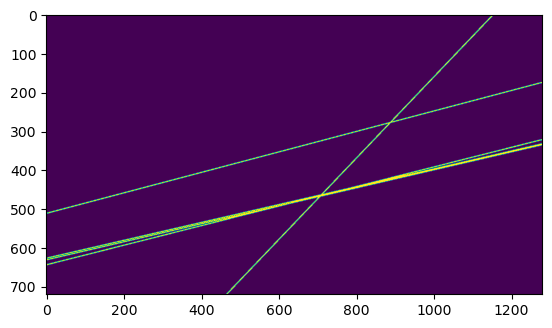

In [31]:
orig_lines = np.asarray(output['intensity_endpoint_lines'])
img = drawPolarLines(img = blank, lines = orig_lines, color = (255, 255, 255))
plt.imshow(img)

In [33]:
hough_lines = orig_lines.copy()
hough_lines

array([[-612.06241197,   -1.7965679 ],
       [-625.51126909,   -1.81724504],
       [-615.7503102 ,   -1.79805159],
       [-495.12712799,   -1.8282354 ],
       [-834.36493214,   -2.37834518]])

In [37]:
new_lines = []
for hough_line in hough_lines:
    rho = hough_line[0]
    theta = hough_line[1]
    if (theta < 0) and (theta >= -np.pi):
        theta += np.pi
        rho *= -1
    elif (theta < -np.pi) and (theta >= -2 * np.pi):
        theta += 2 * np.pi
        rho = rho
    elif (theta >= np.pi) and (theta <= 2 * np.pi):
        theta -= np.pi
        rho *= -1
    new_lines.append([rho, theta])
new_lines = np.asarray(new_lines)
    

In [38]:
new_lines

array([[6.12062412e+02, 1.34502476e+00],
       [6.25511269e+02, 1.32434762e+00],
       [6.15750310e+02, 1.34354107e+00],
       [4.95127128e+02, 1.31335725e+00],
       [8.34364932e+02, 7.63247471e-01]])

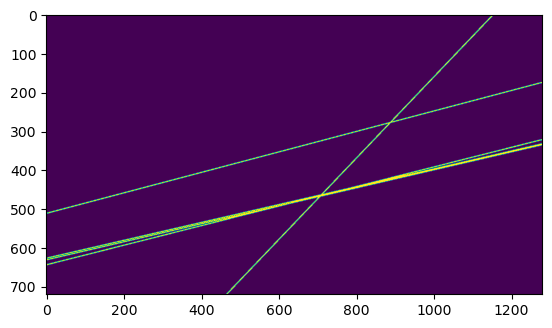

In [39]:
img = drawPolarLines(img = img, lines = new_lines, color = (255, 255, 255))
plt.imshow(img)


In [ ]:
ref_img = np.load('crop_ref_l.npy') # (crop_dims, 3) RGB uint8
ref_img = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
ref_img = K.color.rgb_to_grayscale(ref_img) # [0, 1] torch.Size([1, crop_dims]) torch.float32

crop_ref_dims = np.load('crop_ref_dims.npy') # array([ crop_height, crop_width])
crop_ref_lines = torch.as_tensor(np.load('crop_ref_lines_l.npy')) # torch.Size([2, 2, 2])

data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'].iloc[0]
rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
plt.imshow(rgb)

# load model
model = KF.SOLD2(pretrained=True, config=None)

new_img, y_offset, x_offset = centerCrop(rgb, crop_ref_dims) # crop_dims x 3 (RGB) uint8 ndarray [0 255]
orig_img = new_img.copy()
new_img = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
new_img = K.color.rgb_to_grayscale(new_img) # [0, 1] [1, crop_dims] float32
imgs = torch.stack([ref_img, new_img], )
with torch.inference_mode():
    outputs = model(imgs)

# detect line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]
line_heatmap1 = np.asarray(outputs['line_heatmap'][0])
line_heatmap2 = np.asarray(outputs['line_heatmap'][1])

# perform association between All line segments 
# in ref_img and new_img
with torch.inference_mode():
    matches = model.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# sort matched line segments from ref_img by y-coordinate
sort_column = 0
values, indices = matched_lines1[:, :, sort_column].sort()
sorted_matched_lines1 = matched_lines1[[[x] for x in range(matched_lines1.shape[0])], indices]

# load ref lines and find only those lines in ref_img line segments (matched_lines1)
# using y coordinate
dist_matrix = torch.cdist(torch.flatten(crop_ref_lines, start_dim = 1), torch.flatten(sorted_matched_lines1, start_dim = 1))
ind = torch.argmin(dist_matrix, dim = 1)

# select only matching line segments that correspond to ref lines
selected_lines1 = matched_lines1[ind] # ref lines torch[2, 2, 2]
ref_img = np.load('crop_ref_l.npy')
ref_img = drawLineSegments(ref_img, selected_lines1)
selected_lines2 = matched_lines2[ind] # matched lines in new_img torch[2, 2, 2]
new_img = drawLineSegments(orig_img, selected_lines2)
plt.imshow(new_img)
# new image detected endpoints
detected_endpoints = np.asarray(np.around(np.asarray(selected_lines2), decimals = 0), dtype = int) # [[y, x], [y, x]]

In [ ]:
intensity_endpoint_clouds = None
intensity_endpoint_lines = None

intensity_endpoint_clouds = []
kernel = np.ones((3, 3), np.uint8)

line = detected_endpoints[0]
y1 = line[0][0]
x1 = line[0][1]
y2 = line[1][0]
x2 = line[1][1]

# convert detected endpoints to endpoint intensity clouds
blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
dotted = blank.copy()
dotted[y1, x1] = 255.0
dotted[y2, x2] = 255.0
plt.imshow(dotted)


In [ ]:

dotted_dilation = cv2.dilate(dotted, kernel, iterations = 1)
plt.imshow(dotted_dilation)


In [ ]:
ys, xs = np.where(dotted_dilation)
dilated_points = list(zip(list(ys), list(xs)))
print(dilated_points)


In [ ]:
blank2 = np.zeros_like(dotted_dilation)
for point in dilated_points:
    y = point[0]
    x = point[1]
    blank2[y, x] = 255.0
plt.imshow(blank2)
assert(np.array_equal(blank2,dotted_dilation))

In [ ]:
dilated_points_intensities = np.asarray([line_heatmap2[point[0], point[1]] for point in dilated_points])


In [ ]:

metric = 'mean'
if (metric == 'mean'):
    intensity_threshold = dilated_points_intensities.mean()
elif (metric == 'std'):
    stds = 1
    intensity_threshold = dilated_points_intensities.mean() + (stds * dilated_points_intensities.std())
elif (metric == 'pct'):
    pct = 10.0
    intensity_threshold = np.percentile(dilated_points_intensities, pct)

intensity_mask = dilated_points_intensities >= intensity_threshold
intensity_mask

In [ ]:
thresholded_dilated_points = np.asarray(dilated_points)[intensity_mask]
thresholded_dilated_points


In [ ]:
intensity_endpoint_clouds.append(thresholded_dilated_points)


In [ ]:
# ransac params
min_samples = 2
residual_threshold = 0.1
max_trials = 100

# fit point clouds
cartesian_lines = []
polar_lines = []
cloud = intensity_endpoint_clouds[0]
cloud

In [ ]:

    
# data
X = cloud[:, 1].reshape(-1, 1)
y = cloud[:, 0].reshape(-1, 1)
residual_threshold *= scipy.stats.median_abs_deviation(y, axis = None)
ransac = linear_model.RANSACRegressor(min_samples = min_samples, residual_threshold = residual_threshold, max_trials = max_trials)
    
# sequential ransac
while (True):
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    m = float(ransac.estimator_.coef_[i])
    b = float(ransac.estimator_.intercept_[i])
    cartesian_lines.append([m, b])
    y1, x1 = int(b), 0
    y2, x2 = int(m * crop_ref_dims[1]), crop_ref_dims[1]
    theta = np.arctan2((x1 - x2), (y2 - y1))
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    polar_lines.append([rho, theta])
    X = X[outlier_mask]
    y = y[outlier_mask]
    if (len(X) < min_samples or len(y) < min_samples):
        break

In [60]:
detected_endpoints

array([[[ 335, 1279],
        [ 420,  907]],

       [[ 176, 1279],
        [ 282,  881]]])

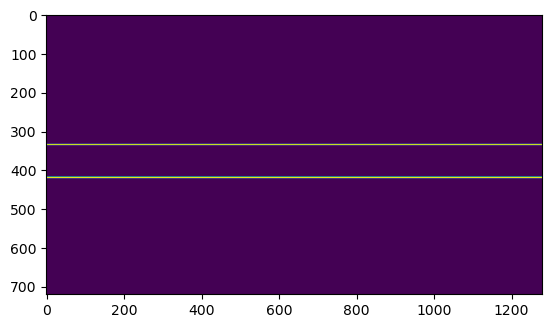

In [61]:
for line in cartesian_lines:
    m = line[0]
    b = line[1]
    y1, x1 = int(b), 0
    y2, x2 = int(m * crop_ref_dims[1] + int(b)), crop_ref_dims[1]
    blank2 = drawLineSegments(blank2, np.asarray([[[y1, x1], [y2, x2]]]))
plt.imshow(blank2)

In [ ]:
polar_lines

In [ ]:
lines

In [ ]:


intensity_endpoint_lines = fitRansacLines(intensity_endpoint_clouds, ransac_params)



In [ ]:

new_img = drawPolarLines(new_img, np.asarray(intensity_endpoint_lines))


In [ ]:
intensity_endpoint_clouds = output['intensity_endpoint_clouds']
ransac_params = kornia_params['ransac_params']
from sklearn import linear_model
import scipy.stats
for cloud in intensity_endpoint_clouds:
    X = cloud[:, 1].reshape(-1, 1)
    print('len(X): {}'.format(len(X)))
    y = cloud[:, 0].reshape(-1, 1)
    print('len(y): {}'.format(len(y)))
    min_samples = int(ransac_params['min_samples'])
    residual_threshold = scipy.stats.median_abs_deviation(y, axis = None) * ransac_params['residual_threshold']
    ransac_lines = []
    while (True):
        ransac = linear_model.RANSACRegressor(min_samples = min_samples, residual_threshold = residual_threshold)
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        m = -1 * float(ransac.estimator_.coef_[i])
        b = float(ransac.estimator_.intercept_[i])
        y1, x1 = int(b), 0
        y2, x2 = int(m * crop_ref_dims[1]), crop_ref_dims[1]
        theta = np.arctan2((x1 - x2), (y2 - y1))
        rho = x1 * np.cos(theta) + y1 * np.sin(theta)
        ransac_lines.append([rho, theta])
        X = X[outlier_mask]
        print('len(X): {}'.format(len(X)))
        y = y[outlier_mask]
        print('len(y): {}'.format(len(y)))
        if (len(X) <= min_samples or len(y) <= min_samples):
            break
ransac_lines

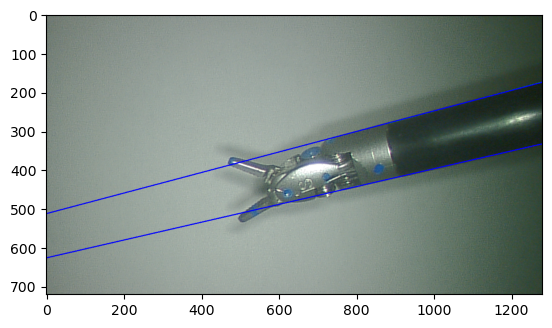

In [17]:
plt.imshow(output['new_img'])

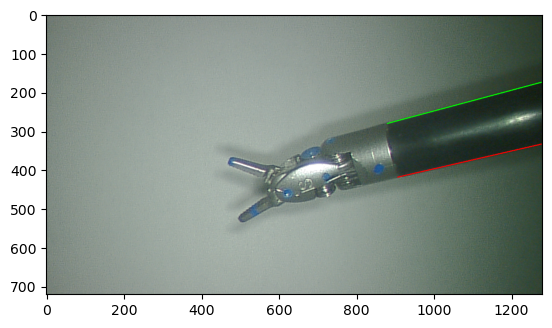

In [18]:
plt.imshow(output['ref_img'])

In [ ]:
# accepts single img and Nx2 [rho, theta] array of line parameters
# returns altered img
def drawPolarLines(img, lines, color = (0, 0, 255)):
    for i in range(lines.shape[0]):
        rho = lines[i, 0]
        theta = lines[i, 1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
        pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
        # BGR (255, 0, 0) = Blue
        cv2.line(img, pt1, pt2, color, 2)
    
    return img

# search intensity endpoints / lines
detected_endpoints = np.asarray(np.around(np.asarray(selected_lines2), decimals = 0), dtype = int) # [[y, x], [y, x]]

# use detected endpoints
# search around detected endpoints
# search around line segment defined by detected endpoints
polar_lines_detected_endpoints = []
intensity_endpoint_clouds = []
intensity_line_clouds = []

# use intensity thresholded points around detected endpoints
# for best fit line -> polar parameterization
polar_lines_detected_endpoints_intensities = []

# use intensity thresholded points around line segment defined by detected endpoints
# for best fit line -> polar parameterization
polar_lines_detected_line_intensities = []

dilation = 5 #kernel size for dilation
kernel = np.ones((dilation, dilation), np.uint8)
#blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
#lined = blank.copy()

for line in detected_endpoints:
    y1 = line[0][0]
    x1 = line[0][1]
    y2 = line[1][0]
    x2 = line[1][1]
    print(y1, x1, y2, x2)
    #blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
    #lined = blank.copy()
    #lined = cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), thickness = 1)
    #plt.imshow(lined)

    # convert detected endpoints to polar coords
    theta = np.arctan2((x1 - x2), (y2 - y1))
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    polar_lines_detected_endpoints.append([rho, theta])
    #blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
    #lined = blank.copy()
    #lined = drawPolarLines(blank, np.asarray([rho, theta]).reshape(-1, 2), color = (255, 255, 255))
    #plt.imshow(lined)

 
    # convert detected endpoints to endpoint intensity clouds
    blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
    dotted = blank.copy()
    dotted[y1, x1] = 255.0
    dotted[y2, x2] = 255.0

    dotted_dilation = cv2.dilate(dotted, kernel, iterations = 1)
    ys, xs = np.where(dotted_dilation)
    dilated_points = list(zip(list(ys), list(xs)))
    dilated_points_intensities = np.asarray([line_heatmap[coord[0], coord[1]] for coord in dilated_points])
    mean_intensity = dilated_points_intensities.mean()
    intensity_mask = dilated_points_intensities > mean_intensity
    thresholded_dilated_points = np.asarray(dilated_points)[intensity_mask]
    intensity_endpoint_clouds.append(thresholded_dilated_points)
    
    # convert detected endpoints to line intensity cloud
    blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
    lined = blank.copy()
    lined = cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), thickness = 1)
    lined_dilation = cv2.dilate(lined, kernel, iterations=1)
    ys, xs = np.where(lined_dilation)
    dilated_line = list(zip(list(ys), list(xs)))
    search_line_intensities = np.asarray([line_heatmap[coord[0], coord[1]] for coord in dilated_line])
    mean_intensity = search_line_intensities.mean()
    intensity_mask = search_line_intensities > mean_intensity
    thresholded_dilated_lines = np.asarray(dilated_line)[intensity_mask]
    intensity_line_clouds.append(thresholded_dilated_lines)

generate best fit lines using RANSAC from intensity endpoint clouds / intensity line clouds
generate rho/theta params for best fit lines
https://scikit-image.org/docs/stable/auto_examples/transform/plot_ransac.html
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn.linear_model.RANSACRegressor

In [ ]:
from sklearn import linear_model
import scipy.stats
X = thresholded_dilated_lines[:, 1].reshape(-1, 1)
y = thresholded_dilated_lines[:, 0].reshape(-1, 1)
min_samples = 3
residual_threshold = scipy.stats.median_abs_deviation(y, axis = None) * 0.1
ransac_lines = []
while (True):
    ransac = linear_model.RANSACRegressor(min_samples = min_samples, residual_threshold = residual_threshold)
    try:
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        m = -1 * float(ransac.estimator_.coef_[i])
        b = float(ransac.estimator_.intercept_[i])
        y1, x1 = int(b), 0
        y2, x2 = int(m * crop_ref_dims[1]), crop_ref_dims[1]
        theta = np.arctan2((x1 - x2), (y2 - y1))
        rho = x1 * np.cos(theta) + y1 * np.sin(theta)
        ransac_lines.append([rho, theta])
        X = X[outlier_mask]
        y = y[outlier_mask]
    except:
        break

In [ ]:
ransac_lines

In [ ]:
ransac.fit(X[outlier_mask].reshape(-1, 1), y[outlier_mask].reshape(-1, 1))
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [ ]:
np.where(outlier_mask)

In [ ]:

scipy.stats.median_abs_deviation(y)

In [ ]:
# convert ransac lines rho, theta params
blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
lined = blank.copy()
for i in range(len(ransac.estimator_.coef_)):
    m = -1 * float(ransac.estimator_.coef_[i])
    b = float(ransac.estimator_.intercept_[i])
    y1, x1 = int(b), 0
    y2, x2 = int(m * crop_ref_dims[1]), crop_ref_dims[1]
    lined = cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), thickness = 1)

    theta = np.arctan2((x1 - x2), (y2 - y1))
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(b)), int(y0 + 2000*(-a)))
    pt2 = (int(x0 - 2000*(b)), int(y0 - 2000*(-a)))
    lined = cv2.line(lined, pt1, pt2, (255, 255, 255), 5)
    
plt.imshow(lined)

In [ ]:
print(m)

In [ ]:
print(b)

In [ ]:
print(y1, x1)

In [ ]:
from scipy.cluster.hierarchy import fclusterdata
# canny edge detection



def detectShaftLines_canny(img):

    # pre-processing
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)

   # detect lines
    lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = 5, theta = 0.09, threshold = 100) 
    lines = np.squeeze(lines)
    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = 5, criterion = 'distance', method = 'complete')
    theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = 0.09, criterion = 'distance', method = 'complete')

    best_lines = []
    checked_clusters = []
    for i in range(sorted_lines.shape[0]):
        rho_cluster = rho_clusters[i]
        theta_cluster = theta_clusters[i]
        cluster = (rho_cluster, theta_cluster)
        if (cluster in checked_clusters):
            continue
        best_lines.append([lines[i, 0], lines[i, 1]])
        checked_clusters.append(cluster)

    best_lines = np.asarray(best_lines)

    # check for negative rho, add 2*pi to theta
    best_lines[:, 1][best_lines[:, 0] < 1] = best_lines[:, 1][best_lines[:, 0] < 1] + 2 * np.pi
    # replace negative rho with abs(rho)
    best_lines[:, 0][best_lines[:, 0] < 0] = best_lines[:, 0][best_lines[:, 0] < 1] * -1

    # eliminate vertical lines
    vertical_line_mask = []
    for i in range(best_lines.shape[0]):
        theta = best_lines[i, 1]
        if (theta > -10 * np.pi / 180) and (theta < 10 * np.pi / 180):
            vertical_line_mask.append(False)
        elif (theta > 170 * np.pi / 180) and (theta < 190 * np.pi / 180):
            vertical_line_mask.append(False)
        else:
            vertical_line_mask.append(True)
    best_lines = best_lines[vertical_line_mask, :]

    # draw all detected and clustered edges
    # (B, G, R)
    img = drawLines(img, best_lines[:, 0:2], color = (0, 0, 255))

    # returns Nx2 array of # N detected lines x [rho, theta], img with lines drawn, edges and mask
    return best_lines[:, 0:2], img

In [ ]:
# create search box
intensity_radius = 3
intensity_endpoints = []
x_min = 0
x_max = crop_ref_dims[1]
y_min = 0
y_max = crop_ref_dims[0]
for i in range(selected_lines2.shape[0]):
    endpoints = selected_lines2[i, :, :]
    print(endpoints)
    for j in range(endpoints.shape[0]):
        y = int(endpoints[j][0])
        x = int(endpoints[j][1])
        top_left = (max(y_min, y - intensity_radius), max(x_min, x - intensity_radius)) 
        bottom_right = (min(y_max, y + intensity_radius), min(x_max, x + intensity_radius))
        rows = np.arange(top_left[0], bottom_right[0])
        cols = np.arange(top_left[1], bottom_right[1])
        intensities = line_heatmap[top_left[0]: bottom_right[0], top_left[1]: bottom_right[1]]
        idx_flat = intensities.ravel().argmax()
        idx = np.unravel_index(idx_flat, intensities.shape)
        y = rows[idx[0]]
        x = cols[idx[1]]
        intensity_endpoints.append([y, x])

intensity_endpoints = torch.as_tensor(np.asarray(intensity_endpoints).reshape(selected_lines2.shape))

In [ ]:
# convert line segment endpoints to rho theta
lines = []
for i in range(intensity_endpoints.shape[0]):
    endpoints = intensity_endpoints[i, :, :]
    y1 = int(endpoints[0][0])
    x1 = int(endpoints[0][1])
    y2 = int(endpoints[1][0])
    x2 = int(endpoints[1][1])
    theta = np.arctan2((x1 - x2), (y2 - y1))
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    lines.append([rho, theta])
lines

Matched lines pixel coordinates in original image size

In [ ]:
detected_pixels = []
line_heatmap = np.asarray(outputs['line_heatmap'][1])
detected_intensities = []

for selected_line in selected_lines2:
    selected_line = torch.round(selected_line, decimals = 0)
    start = (int(selected_line[0][1]), int(selected_line[0][0]))
    end = (int(selected_line[1][1]), int(selected_line[1][0]))
    color = (255, 255, 255)
    thickness = 1 #px
    blank = np.zeros((crop_ref_dims[0], crop_ref_dims[1]))
    lined = cv2.line(blank, start, end, color, thickness)
    
    y = np.where(lined)[0] 
    x = np.where(lined)[1]
    intensities = [line_heatmap[y[i], x[i]] for i in range(len(y))]
    detected_intensities.append(intensities)

    y += y_offset
    x += x_offset
    
    pixels = [list(item) for item in zip(y, x)]
    detected_pixels.append(pixels)

plt.imshow(lined, cmap = 'gray')


In [ ]:
plt.imshow(rgb)

In [ ]:
for pixels in detected_pixels:
    for pixel in pixels:
        y = pixel[0]
        x = pixel[1]
        rgb[y, x, :] = [255, 0, 0]

plt.imshow(rgb)

Projected lines pixel coordinates

In [ ]:
import scipy.stats

# load original size image
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
rgb = raw_string_to_rgb(raw_string = raw_string)

# project [rho, theta] onto original image
proj_lines = np.asarray([[750, 1.3], [875, 1.35]])
projected_pixels = []
for proj_line in proj_lines:
    proj_dict = {}

    sigma2_x = 0.5
    sigma2_y = 0.5

    proj_dict['sigma2_x'] = sigma2_x
    proj_dict['sigma2_y'] = sigma2_y

    rho_hat = proj_line[0]
    theta_hat = proj_line[1]

    proj_dict['rho_hat'] = rho_hat
    proj_dict['theta_hat'] = theta_hat
    var = (np.cos(theta_hat) ** 2) * sigma2_x + (np.sin(theta_hat) ** 2) * sigma2_y
    proj_dict['var'] = var

    a = math.cos(theta_hat)
    b = math.sin(theta_hat)
    x0 = a * rho_hat
    y0 = b * rho_hat
    pt1 = (int(x0 + 2000*(b)), int(y0 + 2000*(-a)))
    pt2 = (int(x0 - 2000*(b)), int(y0 - 2000*(-a)))

    # blank image in original camera size
    blank = np.zeros((rgb.shape[0], rgb.shape[1]))
    image = cv2.line(blank, pt1, pt2, (255, 255, 255), 1)

    pixels = [list(item) for item in zip(np.where(image)[0], np.where(image)[1])] # [y, x]
    proj_dict['pixels'] = pixels

    means = []
    distributions = []
    for i in range(len(pixels)):
        y = pixels[i][0]
        x = pixels[i][1]
        mean = x * np.cos(theta_hat) + y * np.sin(theta_hat) - rho_hat
        means.append(mean)
        distribution = scipy.stats.norm(mean, var)
        distributions.append(distribution)
        

    proj_dict['means'] = means
    proj_dict['distributions'] = distributions

    assert(len(pixels) == len(means) == len(distributions))

    projected_pixels.append(proj_dict)

plt.imshow(image, cmap = 'gray')

Match detected pixels to projected pixels

In [ ]:
# closest points between detected and projected pixels
from scipy.spatial import distance

for i in range(len(projected_pixels)):
    proj_pixels_dict = projected_pixels[i]
    
    proj_pixels = proj_pixels_dict['pixels']
    proj_distributions = proj_pixels_dict['distributions']
    proj_rho_hat = proj_pixels_dict['rho_hat']
    proj_theta_hat = proj_pixels_dict['theta_hat']

    proj_pixels_dict['det_pixels_probs'] = []
    proj_pixels_dict['probs_arith_means'] = []
    proj_pixels_dict['probs_geo_means'] = []
    for j in range(len(detected_pixels)):
        det_pixels = detected_pixels[j]
        det_intensities = detected_intensities[j]
        dist = distance.cdist(det_pixels, proj_pixels, metric = 'euclidean')
        min_indices = np.argmin(dist, axis = 1) # not 1-to-1 matching, many detected match to same projected
        assert(min_indices.shape[0] == len(det_pixels))
        matched_pixels = [proj_pixels[k] for k in min_indices]
        assert(len(matched_pixels) == len(det_pixels))
        matched_distributions = [proj_distributions[l] for l in min_indices]
        assert(len(matched_distributions) == len(det_pixels))
        det_samples = [(det_pixels[m][0] * np.sin(proj_theta_hat) + det_pixels[m][1] * np.cos(proj_theta_hat) - proj_rho_hat) for m in range(len(det_pixels))]
        assert(len(det_samples) == len(det_pixels))
        det_probs = [matched_distributions[n].pdf(det_samples[n]) for n in range(len(det_pixels))]
        det_probs = np.multiply(np.asarray(det_probs), np.asarray(det_intensities))
        assert(len(det_probs) == len(det_pixels))
        proj_pixels_dict['det_pixels_probs'].append([det_pixels, det_probs])
        proj_pixels_dict['probs_arith_means'].append(np.asarray(det_probs).mean())
        proj_pixels_dict['probs_geo_means'].append(scipy.stats.gmean(det_probs))

probs = []
for i in range(len(projected_pixels)):
    proj_pixels_dict = projected_pixels[i]
    probs.append(proj_pixels_dict['probs_arith_means'])
probs = np.asarray(probs)

matched_proj_lines = []
matched_det_lines = []
for i in range(probs.shape[1]):
    sorted_index = np.argsort(-1 * probs[:, i])
    for j in range(len(sorted_index)):
        proj_line = sorted_index[j]
        det_line = i
        if (proj_line not in matched_proj_lines) and (det_line not in matched_det_lines):
            matched_proj_lines.append(proj_line)
            matched_det_lines.append(det_line)

for i in range(len(matched_proj_lines)):
    proj_lines_index = matched_proj_lines[i]
    det_lines_index = matched_det_lines[i]
    projected_pixels[proj_lines_index]['matched_det_line'] = det_lines_index
    projected_pixels[proj_lines_index]['matched_det_line_prob'] = projected_pixels[proj_lines_index]['probs_arith_means'][det_lines_index]
    projected_pixels[proj_lines_index]['matched_det_line_pixels'] = projected_pixels[proj_lines_index]['det_pixels_probs'][det_lines_index][0]
    projected_pixels[proj_lines_index]['matched_det_line_probs'] = projected_pixels[proj_lines_index]['det_pixels_probs'][det_lines_index][1]


SCRATCH

In [7]:
import numpy as np
import cv2
import imutils
import math
from scipy.cluster.hierarchy import fclusterdata
import torch
import kornia as K
from scipy.spatial import distance_matrix
from sklearn import linear_model
import scipy.stats
import kornia.feature as KF
#from PIL import Image
import pandas as pd
import copy
import matplotlib.pyplot as plt

def detectCannyShaftLines(img = None, 
                          hough_rho_accumulator = None, 
                          hough_theta_accumulator = None, 
                          hough_vote_threshold = None,
                          rho_cluster_distance = None,
                          theta_cluster_distance = None 
                          ):

    # pre-processing
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)

   # detect lines
    lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = hough_rho_accumulator, theta = hough_theta_accumulator, threshold = hough_vote_threshold) 
    lines = np.squeeze(lines)
    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    # sort by max votes
    sorted_lines = lines[(-lines[:, 2]).argsort()]

    rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = rho_cluster_distance, criterion = 'distance', method = 'complete')
    theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = theta_cluster_distance, criterion = 'distance', method = 'complete')

    best_lines = []
    checked_clusters = []
    for i in range(sorted_lines.shape[0]):
        rho_cluster = rho_clusters[i]
        theta_cluster = theta_clusters[i]
        cluster = (rho_cluster, theta_cluster)
        if (cluster in checked_clusters):
            continue
        best_lines.append([lines[i, 0], lines[i, 1]])
        checked_clusters.append(cluster)

    best_lines = np.asarray(best_lines)

    # check for negative rho, add 2*pi to theta
    best_lines[:, 1][best_lines[:, 0] < 1] = best_lines[:, 1][best_lines[:, 0] < 1] + 2 * np.pi
    # replace negative rho with abs(rho)
    best_lines[:, 0][best_lines[:, 0] < 0] = best_lines[:, 0][best_lines[:, 0] < 1] * -1

    # eliminate vertical lines
    vertical_line_mask = []
    for i in range(best_lines.shape[0]):
        theta = best_lines[i, 1]
        if (theta > -10 * np.pi / 180) and (theta < 10 * np.pi / 180):
            vertical_line_mask.append(False)
        elif (theta > 170 * np.pi / 180) and (theta < 190 * np.pi / 180):
            vertical_line_mask.append(False)
        else:
            vertical_line_mask.append(True)
    best_lines = best_lines[vertical_line_mask, :]

    # draw all detected and clustered edges
    # (B, G, R)
    img = drawPolarLines(img, best_lines[:, 0:2], color = (0, 0, 255))

    # returns Nx2 array of # N detected lines x [rho, theta], img with lines drawn, edges and mask
    return best_lines[:, 0:2], img

def drawPolarLines(img = None, lines = None, color = (0, 0, 255)):
    lines = lines.reshape(-1, 2)
    for i in range(lines.shape[0]):
        rho = lines[i, 0]
        theta = lines[i, 1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
        pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
        # BGR (255, 0, 0) = Blue
        cv2.line(img, pt1, pt2, color, 2)
    
    return img

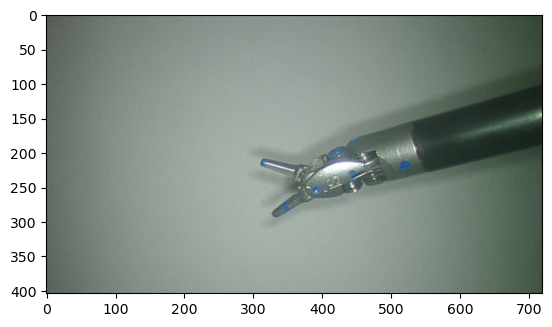

In [8]:
crop_ref_l = np.load('crop_ref_l.npy') # (720, 1080, 3) RGB uint8
plt.imshow(crop_ref_l)

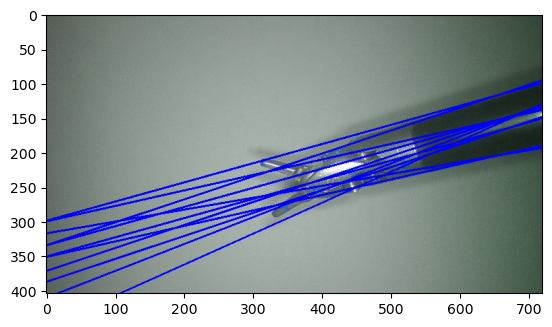

In [9]:
lines, img = detectCannyShaftLines(crop_ref_l, 5, 0.05, 100, 5, 0.05)
plt.imshow(img)

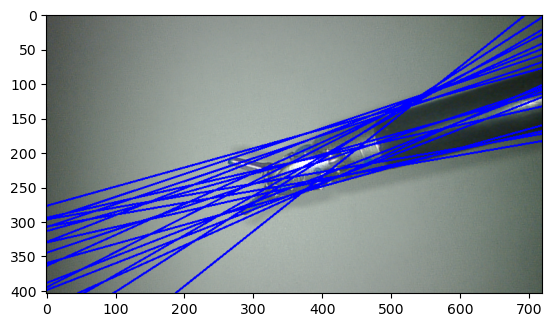

In [20]:
lines, img = detectCannyShaftLines(new_right_img, 5, 0.05, 100, 5, 0.05)
plt.imshow(img)

In [ ]:
import os
import sys

script_path = os.path.dirname(os.path.abspath(''))
module_path = os.path.dirname(script_path)
if module_path not in sys.path:
    sys.path.append(module_path)

print(module_path)

In [ ]:
# isolate lines in new heatmap using local maxima
line_heatmap = np.asarray(outputs['line_heatmap'][1])
junction_heatmap = np.asarray(outputs['junction_heatmap'][1])
plt.imshow(line_heatmap, 'gray')

In [ ]:
# find local maxima
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, binary_erosion
neighborhood = generate_binary_structure(2,2)
local_max = maximum_filter(line_heatmap, footprint = np.ones((3, 3))) == line_heatmap
background = (line_heatmap == 0)
eroded_background = binary_erosion(background, structure = np.ones((3, 3)), border_value = 1)
detected_peaks = local_max ^ eroded_background
plt.imshow(detected_peaks)


In [ ]:
https://www.geeksforgeeks.org/minimum-distance-from-a-point-to-the-line-segment-using-vectors/
https://math.stackexchange.com/questions/2193720/find-a-point-on-a-line-segment-which-is-the-closest-to-other-point-not-on-the-li

In [ ]:
line_heatmap_masked = line_heatmap.copy()
#pixel_coordinates = np.zeros_like(line_heatmap, dtype = np.ndarray)
line_segments = selected_lines2 # endpoints of reported lines
radius = 2 # pixels
for line_segment in line_segments:
    y1, x1, y2, x2 = int(line_segment[0][0]), int(line_segment[0][1]), int(line_segment[1][0]), int(line_segment[1][1])
    #low_y = max((min(y1, y2) - 1), 0)
    #high_y = min((max(y1, y2) + 1), line_heatmap.shape[0])
    #low_x = max((min(x1, x2) - 1), 0)
    #high_x = min((max(x1, x2) + 1), line_heatmap.shape[1])
    start = np.asarray([y1, x1])
    end = np.asarray([y2, x2])
    dist_se = np.linalg.norm(end - start)
    #for y in range(low_y, high_y, 1):
    for y in range(line_heatmap.shape[0]):
        #for x in range(low_x, high_x, 1):
        for x in range(line_heatmap.shape[1]):
            point = np.asarray([y, x])
            t = max(0, min(1, np.dot((point - start), (end - start)) / dist_se))
            projection = start + t * (end - start)
            dist = np.linalg.norm(point - projection)
            if (dist >= 10):
                line_heatmap_masked[y, x] = 0
            else:
                line_heatmap_masked[y, x] = 1

In [ ]:
https://stackoverflow.com/questions/27161533/find-the-shortest-distance-between-a-point-and-line-segments-not-line

In [ ]:

endpoints = selected_lines2
for endpoint in endpoints:
    image = line_heatmap.copy()
    y1, x1, y2, x2 = endpoint[0][0], endpoint[0][1], endpoint[1][0], endpoint[1][1]
    center_coordinates = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    axesLength = (int(abs(x2 - x1) / 2) + 2, 10)
    angle = float(np.arctan2((y2 - y1), (x2 - x1)) * 180 / np.pi)
    startAngle = 0
    endAngle = 360
    color = (1, 1, 1)
    thickness = -1
    image = cv2.ellipse(image, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
plt.imshow(image, 'gray')

In [ ]:
mask = np.zeros_like(line_heatmap)
mask = cv2.ellipse(mask, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
plt.imshow(mask)


In [ ]:
temp = (mask == 0)
line_heatmap_masked = line_heatmap.copy()
line_heatmap_masked[temp] = 0.0
plt.imshow(line_heatmap_masked, 'gray')

In [ ]:
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, binary_erosion
neighborhood = generate_binary_structure(2,100)
local_max = maximum_filter(line_heatmap_masked, footprint = np.ones((3, 3))) == line_heatmap_masked
background = (line_heatmap_masked == 0)
eroded_background = binary_erosion(background, structure = np.ones((3, 3)), border_value = 1)
detected_peaks = local_max ^ eroded_background
plt.imshow(detected_peaks)

SOLD2 (Augmentation)

In [ ]:
'''
# [0, 1] normalize line heatmap for augmentation
line_heatmap = torch.as_tensor(line_heatmap.reshape((-1, 1080, 1920))) # torch.float32 [1, 1080, 1920]
line_heatmap_min = torch.min(line_heatmap)
line_heatmap_max = torch.max(line_heatmap)
line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
line_heatmap -= line_heatmap_min
line_heatmap /= line_heatmap_max
line_heatmap = line_heatmap.view(1, 1080, -1) # [0, 1] torch.float32 [1, 1080, 1920]
print('line_heatmap.shape: {}'.format(line_heatmap.shape))
print('line_heatmap.dtype: {}'.format(line_heatmap.dtype))
# line_heatmap = line_heatmap.float() / 255.0
# plt.imshow(K.tensor_to_image(line_heatmap), 'gray')
#line_heatmap = cv2.cvtColor(line_heatmap, cv2.COLOR_GRAY2RGB) # output is (1080, 1920, 3)
#line_heatmap = K.image_to_tensor(line_heatmap).float() / 255.0
#line_heatmap = K.color.rgb_to_grayscale(line_heatmap)
# plt.imshow(K.tensor_to_image(line_heatmap), 'gray')
'''

'''
# check that the min/max pixels are correctly aligned post-reshape
print(torch.min(img))
print(torch.max(img))
line_heatmap_min = torch.min(line_heatmap)
line_heatmap_max = torch.max(line_heatmap)
print(line_heatmap_min)
print(line_heatmap_max)
indices = (line_heatmap==line_heatmap_max).nonzero()[0]
print(indices)
print(line_heatmap[indices[0], indices[1], indices[2]])
indices = (line_heatmap==line_heatmap_min).nonzero()[0]
print(indices)
print(line_heatmap[indices[0], indices[1], indices[2]])
line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
line_heatmap -= line_heatmap_min
line_heatmap /= line_heatmap_max
line_heatmap = line_heatmap.view(1, 1080, -1)
print(line_heatmap.shape)
print((line_heatmap==torch.max(line_heatmap)).nonzero())
print((line_heatmap==torch.min(line_heatmap)).nonzero())
'''

'''
# show reference image
plt.imshow(K.tensor_to_image(img), 'gray')
'''

'''
# augment reference image with normalized line heatmap and save
augmented_ref = img + line_heatmap # torch.Size([1, 1080, 1920]) float32

# ensure augmented_ref is scaled from 0 to 1
augmented_ref_min = torch.min(augmented_ref)
augmented_ref_max = torch.max(augmented_ref)
augmented_ref = augmented_ref.view(augmented_ref.size(0), -1)
augmented_ref -= augmented_ref_min
augmented_ref /= augmented_ref_max
augmented_ref = augmented_ref.view(1, 1080, -1) # torch.Size([1, 1080, 1920]) float32 [0, 1]
print(augmented_ref.shape)
print(augmented_ref.dtype)
print(augmented_ref.min())
print(augmented_ref.max())
plt.imshow(K.tensor_to_image(augmented_ref), 'gray')
np.save('augmented_ref_l.npy', augmented_ref) # [0, 1] float32 torch.Size([1, 1080, 1920])
# plt.imshow(K.tensor_to_image(img), 'gray')
# line_heatmap_rgb = cv2.cvtColor(line_heatmap, cv2.COLOR_GRAY2RGB) # output is (1080, 1920, 3)
'''
'''
# now do line detection using sold2 augmented ref with new image
augmented_ref = torch.as_tensor(np.load('augmented_ref_l.npy')) # [0, 1] normalized tensor [1, 1080, 1920] float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # (1080, 1920, 3) ndarray uint8 [0, 255]
        print('rgb.shape: {}'.format(rgb.shape))
        print('rgb.dtype: {}'.format(rgb.dtype))
        img = K.image_to_tensor(rgb).float() / 255.0 # [0, 1] torch.float32 [3, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        img = K.color.rgb_to_grayscale(img) # [0, 1] torch.float32 [1, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        imgs = torch.stack([img, img], )

        with torch.inference_mode():
            outputs = sold2(imgs)
        
        # extract reference line heatmap
        line_heatmap = np.asarray(outputs['line_heatmap'][0]) # output is (1080, 1920)

        # [0, 1] normalize
        line_heatmap = torch.as_tensor(line_heatmap.reshape((-1, 1080, 1920))) # torch.float32 [1, 1080, 1920]
        line_heatmap_min = torch.min(line_heatmap)
        line_heatmap_max = torch.max(line_heatmap)
        line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
        line_heatmap -= line_heatmap_min
        line_heatmap /= line_heatmap_max
        line_heatmap = line_heatmap.view(1, 1080, -1) # [0, 1] torch.float32 [1, 1080, 1920]

        # augment image with line heatmap 
        augmented_img = img + line_heatmap # torch.Size([1, 1080, 1920]) float32

        # ensure augmented_img is scaled from 0 to 1
        augmented_img_min = torch.min(augmented_img)
        augmented_img_max = torch.max(augmented_img)
        augmented_img = augmented_img.view(augmented_img.size(0), -1)
        augmented_img -= augmented_img_min
        augmented_img /= augmented_img_max
        augmented_img = augmented_img.view(1, 1080, -1) # torch.Size([1, 1080, 1920]) float32 [0, 1]

        # run inference on augmented ref and augmented new image       
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)

        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})
'''

'''
# now do line matching between augmented image and new image
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)
'''

Canny

Left Camera

In [ ]:
# read first image from left_cam
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0, 255]
plt.imshow(left_cam_reference_rgb)

In [ ]:
left_cam_reference_canny = canny_preprocess(left_cam_reference_rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
plt.imshow(left_cam_reference_canny)

In [ ]:
# augment original camera image with canny edges
assert(left_cam_reference_rgb.min() >= 0)
assert(left_cam_reference_rgb.max() <= 255)
assert(left_cam_reference_canny.min() >= 0)
assert(left_cam_reference_canny.max() <= 255)
temp = np.zeros_like(left_cam_reference_rgb, dtype=np.uint16)
assert(temp.shape == left_cam_reference_rgb.shape == left_cam_reference_canny.shape)
temp += left_cam_reference_rgb
temp += left_cam_reference_canny
temp[temp > 255] = 255
assert(temp.min() >= 0)
assert(temp.max() <= 255)
augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
assert(augmented_img.min() >= 0)
assert(augmented_img.max() <= 255)
assert(augmented_img.shape == left_cam_reference_rgb.shape == left_cam_reference_canny.shape)
plt.imshow(augmented_img)
np.save('canny_augmented_ref_l.npy', augmented_img) # (1080, 1920, 3) RGB uint8

In [ ]:
# use canny augmented ref as ref image
augmented_ref = np.load('canny_augmented_ref_l.npy') # (1080, 1920, 3) RGB uint8
augmented_ref = K.image_to_tensor(augmented_ref).float() / 255.0 # [0, 1] torch.Size([3, 1080, 1920]) torch.float32
augmented_ref = K.color.rgb_to_grayscale(augmented_ref) # [0, 1] torch.Size([1, 1080, 1920]) torch.float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        canny = canny_preprocess(rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        temp = np.zeros_like(rgb, dtype=np.uint16)
        assert(temp.shape == rgb.shape == canny.shape)
        temp += rgb
        temp += canny
        temp[temp > 255] = 255
        augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 255)
        augmented_img = K.image_to_tensor(augmented_img).float() / 255.0  # [0, 1] [3, 1080, 1920] float32
        assert(augmented_img.shape == (3, 1080, 1920))
        augmented_img = K.color.rgb_to_grayscale(augmented_img) # [0, 1] [1, 1080, 1920] float32
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 1)
        assert(augmented_ref.min() >= 0)
        assert(augmented_ref.max() <= 1)
        assert(augmented_img.shape == augmented_ref.shape == (1, 1080, 1920))
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

In [ ]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

In [ ]:
# pick only shaft lines
reference_line_lengths = []
for i in range(matched_lines1.shape[0]):
    reference_line_lengths.append(np.linalg.norm(matched_lines1[i][0] - matched_lines1[i][1]))
reference_line_lengths = np.asarray(reference_line_lengths)
ind = np.argpartition(reference_line_lengths, -2)[-2:]
print(ind)

In [ ]:
# plot matched shaft lines only
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
selected_lines1 = matched_lines1[ind]
selected_lines2 = matched_lines2[ind]
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

In [ ]:
# save reference shaft lines in y = mx + b format
ref_lines = []
for i in range(selected_lines1.shape[0]):
    x1, y1, x2, y2 = selected_lines1[i][0][1], selected_lines1[i][0][0], selected_lines1[i][1][1], selected_lines1[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    ref_lines.append([float(m), float(b)])
np.save('ref_lines.npy', np.asarray(ref_lines)) # 2x2 np array [[m, b], [m, b]]

# confirm reference lines are accurate
ref_lines = np.load('ref_lines.npy')
image_height = 1080
image_width = 1920
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR

for line in ref_lines:
    m = line[0]
    b = line[1]
    x0 = int(0)
    y0 = int(m * x0 + b)
    x1 = int(image_width)
    y1 = int(m * x1 + b)
    image = cv2.line(image, (x0, y0), (x1, y1), (255, 0, 0), 10)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    

In [ ]:
# process new images using canny augmented ref as ref image
augmented_ref = np.load('canny_augmented_ref_l.npy') # (1080, 1920, 3) RGB uint8
augmented_ref = K.image_to_tensor(augmented_ref).float() / 255.0 # [0, 1] torch.Size([3, 1080, 1920]) torch.float32
augmented_ref = K.color.rgb_to_grayscale(augmented_ref) # [0, 1] torch.Size([1, 1080, 1920]) torch.float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        canny = canny_preprocess(rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        temp = np.zeros_like(rgb, dtype=np.uint16)
        assert(temp.shape == rgb.shape == canny.shape)
        temp += rgb
        temp += canny
        temp[temp > 255] = 255
        augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 255)
        augmented_img = K.image_to_tensor(augmented_img).float() / 255.0  # [0, 1] [3, 1080, 1920] float32
        assert(augmented_img.shape == (3, 1080, 1920))
        augmented_img = K.color.rgb_to_grayscale(augmented_img) # [0, 1] [1, 1080, 1920] float32
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 1)
        assert(augmented_ref.min() >= 0)
        assert(augmented_ref.max() <= 1)
        assert(augmented_img.shape == augmented_ref.shape == (1, 1080, 1920))
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

In [ ]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches] # torch.Size([30, 2, 2])
matched_lines2 = line_seg2[match_indices]

# load ref lines and find identical lines in matched_lines1
# then find matching lines in matched_lines2
ref_lines = np.load('ref_lines.npy') # 2x2 numpy array [[m, b], [m, b]]
matched_lines1_ymxb = []
for i in range(matched_lines1.shape[0]):
    x1, y1, x2, y2 = matched_lines1[i][0][1], matched_lines1[i][0][0], matched_lines1[i][1][1], matched_lines1[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    matched_lines1_ymxb.append([float(m), float(b)])
matched_lines1_ymxb = np.asarray(matched_lines1_ymxb)
dist = distance_matrix(ref_lines, matched_lines1_ymxb)
ind = np.argmin(dist, axis = 1)
selected_lines1 = matched_lines1[ind]
selected_lines2 = matched_lines2[ind] # torch.Size([2, 2, 2])

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

Measuring error

In [ ]:
# convert selected_lines2 from new image to y = mx + b
selected_lines2_ymxb = []
for i in range(selected_lines2.shape[0]):
    x1, y1, x2, y2 = selected_lines2[i][0][1], selected_lines2[i][0][0], selected_lines2[i][1][1], selected_lines2[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    selected_lines2_ymxb.append([float(m), float(b)])

# confirm selected lines are accurate
image_height = 1080
image_width = 1920
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR

for line in selected_lines2_ymxb:
    m = line[0]
    b = line[1]
    x0 = int(0)
    y0 = int(m * x0 + b)
    x1 = int(image_width)
    y1 = int(m * x1 + b)
    image = cv2.line(image, (x0, y0), (x1, y1), (255, 0, 0), 10)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Plotting projected lines

In [ ]:
# simulate projected lines from FK
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
proj_lines = np.asarray([[750, 1.3], [875, 1.35]])
proj_lines_ymxb = []
for proj_line in proj_lines:
    rho = proj_line[0]
    theta = proj_line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(b)), int(y0 + 2000*(-a)))
    pt2 = (int(x0 - 2000*(b)), int(y0 - 2000*(-a)))
    image = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
    x1, y1, x2, y2 = pt1[0], pt1[1], pt2[0], pt2[1]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    proj_lines_ymxb.append([m, b])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
proj_lines_ymxb = np.asarray(proj_lines_ymxb)
selected_lines2_ymxb = np.asarray(selected_lines2_ymxb)
dist = distance_matrix(proj_lines_ymxb, selected_lines2_ymxb)
print(dist)
ind = np.argmin(dist, axis = 1)
print(ind.shape[0])
line_pairs_ymxb = []
line_pairs_pts = []
for i in range(ind.shape[0]):
    line_pairs_ymxb.append([proj_lines_ymxb[i, :], selected_lines2_ymxb[ind[i], :]])
    proj_line_m, proj_line_b = proj_lines_ymxb[i, 0], proj_lines_ymxb[i, 1]
    selected_line_m, selected_line_b = selected_lines2_ymxb[ind[i], 0], selected_lines2_ymxb[ind[i], 1]
    line_pairs_pts.append([[proj_line_m * x + proj_line_b for x in range(0, image_width)], [selected_line_m * x + selected_line_b for x in range(0, image_width)]])
line_pairs_pts = np.asarray(line_pairs_pts)

In [ ]:
errors = []
vars = []
for i in range(line_pairs_pts.shape[0]):
    proj_pts = line_pairs_pts[i, 0, :]
    selected_pts = line_pairs_pts[i, 1, :]
    error = proj_pts - selected_pts
    print(error.shape)
    var = ((error- np.mean(error))**2).mean()
    print(var.shape)
    errors.append(error)
    vars.append(var)

errors = np.asarray(errors)
vars = np.asarray(vars)
cov = np.cov(errors[0, :], errors[1, :])[0, 1]
var = vars.sum() + 2 * cov
print(errors.shape)
print(vars)
print(cov)
print(var)


SCRATCH

In [ ]:
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
rho = 750
theta = 1.3
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
img = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
rho = 875
theta = 1.35
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
img = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
# read images from csv without saving to PIL saved PNG
# check for equality
# read first image from left_cam 
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string)
left_cam_reference_rgb = K.image_to_tensor(left_cam_reference_rgb).float() / 255.0 # direct to RGB tensor (kornia_load_img converts from BGR to RGB first because read-in saved image is stored BGR)
assert(np.array_equal(left_cam_reference_rgb, torch_left_ref))
left_cam_reference_gray = K.color.rgb_to_grayscale(left_cam_reference_rgb)
assert(np.array_equal(left_cam_reference_gray, torch_left_ref_gray))

left_cam_reference_canny = raw_string_to_rgb(raw_string = raw_string)
left_cam_reference_canny = canny_preprocess(left_cam_reference_canny)
left_cam_reference_canny = K.image_to_tensor(left_cam_reference_canny).float() / 255.0 # direct to RGB tensor (kornia_load_img converts from BGR to RGB first because read-in saved image is stored BGR)
assert(np.array_equal(left_cam_reference_canny, torch_left_ref_canny))
left_cam_reference_gray_canny = K.color.rgb_to_grayscale(left_cam_reference_canny)
assert(np.array_equal(left_cam_reference_gray_canny, torch_left_ref_gray_canny))

In [ ]:
grey = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap = 'gray')

In [ ]:
blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
plt.imshow(blur, cmap = 'gray')

In [ ]:

thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(mask, cmap = 'gray')

In [ ]:
edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
plt.imshow(edges, cmap = 'gray')


In [ ]:
edges_and_mask = cv2.bitwise_and(edges, mask)
plt.imshow(edges_and_mask)


In [ ]:

lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = 5, theta = 0.09, threshold = 100) 
lines = np.squeeze(lines)
# sort by max votes
sorted_lines = lines[(-lines[:, 2]).argsort()]
for i in range(sorted_lines.shape[0]):
    rho = sorted_lines[i, 0]
    theta = sorted_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(rgb, pt1, pt2, (0,0,255), 2)
plt.imshow(rgb)


In [ ]:

rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = 5, criterion = 'distance', method = 'complete')
theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = 0.09, criterion = 'distance', method = 'complete')

best_lines = []
checked_clusters = []
for i in range(sorted_lines.shape[0]):
    rho_cluster = rho_clusters[i]
    theta_cluster = theta_clusters[i]
    cluster = (rho_cluster, theta_cluster)
    if (cluster in checked_clusters):
        continue
    best_lines.append([lines[i, 0], lines[i, 1]])
    checked_clusters.append(cluster)

best_lines = np.asarray(best_lines)

for i in range(best_lines.shape[0]):
    rho = best_lines[i, 0]
    theta = best_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    cv2.line(rgb, pt1, pt2, (255,0,0), 2)
plt.imshow(rgb)

In [15]:
from scipy import optimize
import numpy as np
projected_point = np.asarray([99, 116]).reshape(-1, 2)
point_detections = np.asarray([
    [135.16666667, 175.92337165],
    [150.20910209, 157.95571956],
    [186.13438735, 153.05928854],
    [265.76923077, 140.20928621],
    [290.0,         130.        ],
    [331.0,        124.        ],
    [118.43174603,  95.5015873 ],
    [424.82491582,  93.17508418],
    [389.0,          79.        ],
    [335.0,          70.        ]
])
projected_point.shape

(1, 2)

In [19]:
projected_point[:, None, :].shape

(1, 1, 2)

In [20]:
point_detections[None, :, :].shape

(1, 10, 2)

In [16]:

C = np.linalg.norm(projected_point[:, None, :] - point_detections[None, :,  :], axis=2)

In [17]:
C

array([[ 69.99170128,  66.20162038,  94.68786789, 168.51725689,
        191.51240169, 232.13789006,  28.24495843, 326.62341091,
        292.35081666, 240.44126102]])

In [ ]:

row_idx, col_idx = optimize.linear_sum_assignment(C)

In [8]:
import rosbag
import numpy as np
bag = rosbag.Bag('../../journal_dataset/stationary_camera_2020-06-24-15-49-10.bag')

left_camera_topic  = '/stereo/left/image'
right_camera_topic = '/stereo/right/image'
robot_joint_topic  = '/dvrk/PSM1/state_joint_current'
robot_gripper_topic = '/dvrk/PSM1/state_jaw_current'

count = 0
old_l_img_msg = None
old_r_img_msg = None
old_j_msg = None
old_g_msg = None
l_img_msg = None
r_img_msg = None
j_msg = None
g_msg = None

for topic, msg, t in bag.read_messages(topics=[left_camera_topic, right_camera_topic, robot_joint_topic, robot_gripper_topic]):
    if topic == '/stereo/left/image':
        l_img_msg = msg
    if topic == '/stereo/right/image':
        r_img_msg = msg
    if topic == '/dvrk/PSM1/state_joint_current':
        j_msg = msg
    if topic == '/dvrk/PSM1/state_jaw_current':
        g_msg = msg
    
    if (l_img_msg) and (r_img_msg) and (j_msg) and (g_msg):
        print('l_img_msg: {}'.format(l_img_msg))
        print('r_img_msg: {}'.format(l_img_msg))
        print('j_msg: {}'.format(l_img_msg))
        print('g_msg: {}'.format(l_img_msg))
        break
    
bag.close()


_cb_left_img  = np.ndarray(shape=(l_img_msg.height, l_img_msg.width, 3), dtype=np.uint8, buffer=l_img_msg.data)
_cb_right_img = np.ndarray(shape=(r_img_msg.height, r_img_msg.width, 3), dtype=np.uint8, buffer=r_img_msg.data)
cb_joint_angles = np.array(j_msg.position + g_msg.position)
